This notebook contains our simplified final solution. We have already [published](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/154305) all separate parts of it and this notebook is the end-to-end solution reproducing 0.813 result.

# DSL solving 8 tasks (3Grid+5Tiles)

Link to the [separate notebook](https://www.kaggle.com/golubev/arc-8solved-3grid-5tiles-no-ml).

# To run,
change the data_dir to the directory in which the problem json files are stored. The path is relative to `/kaggle/input/` if that directory exists, otherwise it is relative to the current directory. For example, if `data_dir = arc-datasets/small_test`, then the script will first check to see if `/kaggle/input/` exists as a directory; it it does, it will make the data directory `/kaggle/input/arc-datasets/small_test`. Otherwise, it will make the data directory `./arc-datasets/small_test`. 

Furthermore, the script also expects a `training` and `evaluation` in the parent directory of `data_dir`. For instance, if `data_dir = arc-datasets/small_test` as before, then the script expects two directories, `arc-datasets/training` and `arc-datasets/evaluation`, to also exist.

In [1]:
import os

In [2]:
data_dir = os.path.join('arc-datasets', 'small_dataset_0')

In [3]:
# Parameters
data_dir = "arc-datasets/small_dataset_0"


In [4]:
import numpy as np
import pandas as pd
import sys

import json
from pathlib import Path

from skimage.measure import label, regionprops
from itertools import combinations, product
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import colors

if os.path.exists('/kaggle/input/'):
    base_path = '/kaggle/input/'
else:
    base_path = ".."

dir_of_data_dirs = os.path.join(os.path.dirname(data_dir))

other_data_dir = Path(os.path.join(base_path, dir_of_data_dirs))

test_path = Path(os.path.join(base_path, data_dir))

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [5]:
# sample_submission_path = "/kaggle/input/sample-submission/sample_submission.csv"
import os
import json
import pandas as pd

tasks = sorted([f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f)) and f.split(".")[-1] == "json"])

problems = []
for task in tasks:
    task_path = os.path.join(test_path, task)
    task_name =  task.split(".")[0]
    with open(task_path) as taskf:
        taskj = json.load(taskf)
        problem_count = len(taskj["test"])
        for i in range(problem_count):
            problems.append(task_name + "_" + str(i))


sample_submission = pd.DataFrame({"output_id": problems})
sample_submission["output"] = "|3| |2| |1|"
sample_submission.to_csv("sample_submission.csv")

In [6]:
def get_objects(task):
    xs, ys = [], []
    for obj in task['train']:
        xs.append(np.array(obj['input']))
        ys.append(np.array(obj['output']))
    return xs, ys

def find_sub(matrix, sub, ignore = None):
    positions = []
    mask = sub != ignore
    sub_ = sub[mask]
    for x in range(matrix.shape[0]-sub.shape[0]+1):
        for y in range(matrix.shape[1]-sub.shape[1]+1):
            if np.array_equal(matrix[x:x+sub.shape[0], y:y+sub.shape[1]][mask], sub_):
                positions.append((x,y,x+sub.shape[0],y+sub.shape[1]))
    return positions

def check_subitem(task):
    for x, y in zip(*get_objects(task)):
        positions = find_sub(x, y)
        if len(positions) == 0:
            return False
    return True
            
def check_samesize(task):
    for x,y in zip(*get_objects(task)):
        if x.shape != y.shape:
            return False
    return True

def check_sub_mask(task):
    if check_samesize(task):
        return False
    for x,y in zip(*get_objects(task)):
        colors, counts = np.unique(x, return_counts=True)
        found = 0
        for c, area in zip(colors, counts):
            cxs, cys = np.where(x == c)
            xmin,ymin,xmax,ymax = min(cxs),min(cys),max(cxs)+1,max(cys)+1
            shape = (xmax-xmin, ymax-ymin)
            if shape == y.shape and area == np.prod(y.shape):
                found += 1
        if found != 1:
            return False
    return True

def get_cells(x, cols, rows):
    if cols[0] != 0:
        cols = [-1]+cols
    if rows[0] != 0:
        rows = [-1]+rows
    if cols[-1] != x.shape[0]-1:
        cols.append(x.shape[0])
    if rows[-1] != x.shape[1]-1:
        rows.append(x.shape[1])
    cells = np.full((len(cols)-1, len(rows)-1), np.object)
    for i in range(len(cols)-1):
        for j in range(len(rows)-1):
            cells[i][j] = x[cols[i]+1:cols[i+1], rows[j]+1:rows[j+1]]
    return cells

def get_grid(x):
    cols = defaultdict(list)
    rows = defaultdict(list)
    if x.shape[0] < 3 or x.shape[1] < 3:
        return -1, [], []
    for i in range(x.shape[0]):
        if len(np.unique(x[i])) == 1:
            cols[x[i,0]].append(i)
    for i in range(x.shape[1]):
        if len(np.unique(x[:,i])) == 1:
            rows[x[0,i]].append(i)
    for c in cols:
        if c in rows and all(np.diff(cols[c])>1) and all(np.diff(rows[c])>1):
            return c, cols[c], rows[c]
    return -1, [], []

def check_grid(task):
    for x,y in zip(*get_objects(task)):
        color_of_grid, cols, rows = get_grid(x)
        if color_of_grid == -1:
            return False
    return True

In [7]:
def mul_ratio(x, x_ratio):
    x_shape = (x.shape[0]*x_ratio[0], x.shape[1]*x_ratio[1])
    x_ = np.array([x[i//x_ratio[0]][j//x_ratio[1]] for i, j in np.ndindex(x_shape)]).reshape(x_shape)
    return x_

def predict_transforms(xs, ys, test):
    fn = get_transform(xs, ys)
    if fn:
        return [fn(test)]
    ratio = get_ratio(xs, ys)
    if ratio:
        x_ratio, y_ratio = ratio
        xs_ = []
        ys_ = []
        for x, y in zip(xs, ys):
            x, y = mul_ratios(x, y, x_ratio, y_ratio)
            xs_.append(x)
            ys_.append(y)
        fn = get_transform(xs_, ys_)
        if fn:
            test = mul_ratio(test, x_ratio)
            return [fn(test)]
        fns = np.full(x_ratio, np.object)
        for i, j in np.ndindex(x_ratio):
            ys_ = []
            for y in ys:
                m1 = y.shape[0]//x_ratio[0]
                m2 = y.shape[1]//x_ratio[1]
                ys_.append(y[i*m1:(i+1)*m1,j*m2:(j+1)*m2])
            fn = get_transform(xs, ys_)
            if fn:
                fns[i,j] = fn
            else:
                return []
        return [np.concatenate([np.concatenate([fns[i,j](test) for i in range(x_ratio[0])], axis=0) for j in range(x_ratio[1])], axis=1)]
    return []

def predict_grid_transforms(task, test):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return predict_transforms(xs, ys, grid_filter(test))

def get_transform(xs, ys):
    for tranform in get_all_transforms():
        tranformed = True
        for x, y in zip(xs, ys):
            if tranform(x).shape != y.shape:
                tranformed = False
                break
            if not np.equal(tranform(x), y).all():
                tranformed = False
        if tranformed:
            return tranform
    return None

def get_transforms(xs, ys):
    fn = get_transform(xs, ys)
    if fn:
        return fn
    ratio = get_ratio(xs, ys)
    if ratio:
        x_ratio, y_ratio = ratio
        xs_ = []
        ys_ = []
        for x, y in zip(xs, ys):
            x, y = mul_ratios(x, y, x_ratio, y_ratio)
            xs_.append(x)
            ys_.append(y)
        fn = get_transform(xs_, ys_)
        if fn:
            return fn
        fns = np.full(x_ratio, np.object)
        for i, j in np.ndindex(x_ratio):
            ys_ = []
            for y in ys:
                m1 = y.shape[0]//x_ratio[0]
                m2 = y.shape[1]//x_ratio[1]
                ys_.append(y[i*m1:(i+1)*m1,j*m2:(j+1)*m2])
            fn = get_transform(xs, ys_)
            if fn:
                fns[i,j] = fn
            else:
                return None
        return fns
    return None

def check_grid_transforms(task):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return get_transforms(xs, ys) is not None

def get_mode_color(ar):
    colors, counts = np.unique(ar, return_counts=True)
    return colors[np.argmax(counts)]

def grid_filter(x):
    color_of_grid, cols, rows = get_grid(x)
    if color_of_grid == -1:
        return x
    cells = get_cells(x, cols, rows)
    return np.array([get_mode_color(cell) for cell in cells.reshape(-1)]).reshape(cells.shape)

def mul_ratios(x, y, x_ratio, y_ratio):
    x_shape = (x.shape[0]*x_ratio[0], x.shape[1]*x_ratio[1])
    x_ = np.array([x[i//x_ratio[0]][j//x_ratio[1]] for i, j in np.ndindex(x_shape)]).reshape(x_shape)
    y_shape = (y.shape[0]*y_ratio[0], y.shape[1]*y_ratio[1])
    y_ = np.array([y[i//y_ratio[0]][j//y_ratio[1]] for i, j in np.ndindex(y_shape)]).reshape(y_shape)
    return x_, y_

def get_ratio(xs, ys):
    x_ratio = []
    y_ratio = []
    for i in range(2):
        if   all(x.shape[i]%y.shape[i] == 0  for x, y in zip(xs, ys)):
            if len(set(x.shape[i]//y.shape[i] for x, y in zip(xs, ys))) == 1:
                x_ratio.append(1)
                y_ratio.append(xs[0].shape[i]//ys[0].shape[i])
        elif all(y.shape[i]%x.shape[i] == 0  for x, y in zip(xs, ys)):
            if len(set(y.shape[i]//x.shape[i] for x, y in zip(xs, ys))) == 1:
                x_ratio.append(ys[0].shape[i]//xs[0].shape[i])
                y_ratio.append(1)
    if len(x_ratio) != 2:
        return None
    return tuple(x_ratio), tuple(y_ratio)

def check_sub_grid_2x(task):
    if check_samesize(task) or check_subitem(task):
        return False
    for x,y in zip(*get_objects(task)):
        color_of_grid, cols, rows = get_grid(x)
        if color_of_grid == -1:
            return False
        cells = grid_filter(x)
        if (cells.shape[0]*2 != y.shape[0] or cells.shape[1]*2 != y.shape[1]):
            return False
    return True

def check_chess(task, input=False, output=True):
    xs, ys = get_objects(task)
    if input:
        for x in xs:
            if not has_chess(x) and not has_antichess(x):
                return False
    if output:
        for y in ys:
            if not has_chess(y) and not has_antichess(y):
                return False
    return True

def has_chess(g):
    colors = np.unique(g)
    counts = len(colors)
    if counts < 2:
        return False
    indexes = np.zeros(counts, bool)
    for c in colors:
        pts = np.where(g == c)
        s = set([(x+y)%counts for x, y in zip(*pts)])
        if len(s) > 1:
            return False
        index = s.pop()
        if indexes[index]:
            return False
        indexes[index] = True
    return True

def has_antichess(g):
    colors = np.unique(g)
    counts = len(colors)
    if counts < 2:
        return False
    indexes = np.zeros(counts, bool)
    for c in colors:
        pts = np.where(g == c)
        s = set([(g.shape[0]-x+y-1)%counts for x, y in zip(*pts)])
        if len(s) > 1:
            return False
        index = s.pop()
        if indexes[index]:
            return False
        indexes[index] = True
    return True

def find_colors(g):
    colors = np.unique(g)
    counts = len(colors)
    for cnt in range(counts, 1, -1):
        q_colors = np.full(cnt, -1, int)
        for c in colors:
            pts = np.where(g == c)
            s = set([(x+y)%cnt for x, y in zip(*pts)])
            if len(s) > 1:
                continue
            index = s.pop()
            q_colors[index] = c
        
        if -1 not in q_colors:
            return q_colors
    return None

def predict_chess(g):
    q_colors = find_colors(g)
    if q_colors is None:
        colors, counts = np.unique(g, return_counts=True)
        q_colors = colors[np.argsort(counts)][:2]
        
    results = []
    counts = len(q_colors)
    for i in range(counts):
        result = g.copy()
        for x, y in np.ndindex(g.shape):
            result[x,y] = q_colors[(x+y)%counts]
        results.append(result)
        q_colors = np.roll(q_colors, 1)
    return results

def predict_transforms_grid_2x(task, test):
    xs, ys = get_objects(task)
    xs = [grid_filter(x) for x in xs]
    return predict_transforms_2x(xs, ys, grid_filter(test))

def predict_transforms_2x(xs, ys, test):
    predictions = []
    transforms = [
        lambda x: np.rot90(x.T, k=1),
        lambda x: np.rot90(x.T, k=3),
        lambda x: np.rot90(x, k=2),
        lambda x: x,
    ]
    quads = [(1,3,2,0),(3,1,0,2),(2,0,1,3)] # 3 full symmetrical shapes
    for f1,f2,f3,f4 in quads:
        fns = np.array([[transforms[f1],transforms[f2]],[transforms[f3],transforms[f4]]])
        x_ = np.concatenate([np.concatenate([fns[i,j](test) for i in range(2)], axis=0) for j in range(2)], axis=1)
        predictions.append(x_)
    return predictions

def has_repeating(g, ignore=0):
    size0b = int(.6 * g.shape[0])
    size1b = int(.6 * g.shape[1])
    t = np.full((g.shape[0]+2*size0b,g.shape[1]+2*size1b), -1)
    t[size0b:-size0b,size1b:-size1b] = g
    t[t==ignore] = -1
    for size0 in range(2, size0b+1):
        for size1 in range(2, size1b+1):
            for shift0 in range(size0):
                for shift1 in range(size1):
                    pattern = t[size0b+shift0:size0b+shift0+size0,size1b+shift1:size1b+shift1+size1].copy()
                    found = True
                    for d0 in range(size0b+shift0-size0, t.shape[0]-size0, size0):
                        for d1 in range(size1b+shift1-size1, t.shape[1]-size1, size1):
                            test = t[d0:d0+size0,d1:d1+size1]
                            mask = (test != -1) & (pattern != -1)
                            if np.array_equal(test[mask], pattern[mask]):
                                ind = test != -1
                                pattern[ind] = test[ind]
                            else:
                                found = False
                                break
                    if found:
                        return shift0, shift1, pattern
    return None

def check_repeating(task, has_complete=False):
    patterns = []
    for x, y in zip(*get_objects(task)):
        if len(np.unique(x)) < 3 or not has_repeating(y,-1):
            return False
        result = None
        for c in np.unique(x):
#             if c not in np.unique(y):
            result = has_repeating(x,c)
            if result:
                sh0,sh1,pattern = result
                pattern[pattern == -1] = c
                if has_complete:
                    pred = np.tile(pattern, (x.shape[0]//pattern.shape[0]+2, x.shape[1]//pattern.shape[1]+2))
                    pred1 = pred[sh0:sh0+x.shape[0],sh1:sh1+x.shape[1]]
                    pred2 = pred[sh0+1:sh0+1+x.shape[0],sh1:sh1+x.shape[1]]
                    pred3 = pred[sh0:sh0+x.shape[0],sh1+1:sh1+1+x.shape[1]]
                    if np.array_equal(pred1, y) or np.array_equal(pred2, y) or np.array_equal(pred3, y):
                        break
                    result = None
                else:
                    break
        if not result:
            return False
    return True

def predict_repeating(x):
    for c in np.unique(x):
        result = has_repeating(x, c)
        if result:
            sh0,sh1,pattern = result
            pattern[pattern == -1] = c
            pred = np.tile(pattern, (x.shape[0]//pattern.shape[0]+2, x.shape[1]//pattern.shape[1]+2))
            pred1 = pred[sh0:sh0+x.shape[0],sh1:sh1+x.shape[1]]
            pred2 = pred[sh0+1:sh0+1+x.shape[0],sh1:sh1+x.shape[1]]
            pred3 = pred[sh0:sh0+x.shape[0],sh1+1:sh1+1+x.shape[1]]
            return [pred1,pred2,pred3]
    return []

def predict_repeating_mask(x):
    predictions = predict_repeating(x)
    if len(predictions) > 0:
        rows, cols = np.where(predictions[0] != x)
        return [predictions[0][min(rows):max(rows)+1,min(cols):max(cols)+1]]
    return []

def trim_matrix(x):
    if len(np.unique(x)) == 1:
        return x
    for c in np.unique(x):
        xs,ys = np.where(x!=c)
        xmin,ymin,xmax,ymax = min(xs),min(ys),max(xs)+1,max(ys)+1
        if xmin > 0 or ymin > 0 or xmax < x.shape[0] or ymax < x.shape[1]:
            return x[xmin:xmax,ymin:ymax]
    return x

def trim_matrix_box(g, mask=None):
    if mask is None:
        mask = np.unique(g)
    if len(np.unique(g)) == 1:
        return None
    for c in mask:
        xs,ys = np.where(g!=c)
        xmin,ymin,xmax,ymax = min(xs),min(ys),max(xs)+1,max(ys)+1
        if xmin > 0 or ymin > 0 or xmax < g.shape[0] or ymax < g.shape[1]:
            return (xmin,ymin,xmax,ymax)
    return None

def has_tiles(g, ignore=0):
    for size0b, size1b in [(g.shape[0], int(0.6*g.shape[1])), (int(0.6*g.shape[0]), g.shape[1])]:
        t = np.full((g.shape[0]+size0b, g.shape[1]+size1b), -1)
        t[:-size0b,:-size1b] = g
        t[t==ignore] = -1
        box_trim = trim_matrix_box(g,[ignore])
        min_size0 = 1
        min_size1 = 1
        if box_trim is not None and ignore != -1:
            xmin,ymin,xmax,ymax = box_trim
            t[xmin:xmax,ymin:ymax] = g[xmin:xmax,ymin:ymax]
            min_size0 = xmax-xmin
            min_size1 = ymax-ymin
        for size0 in range(min_size0, size0b+1):
            for size1 in range(min_size1, size1b+1):
                pattern = t[:size0,:size1].copy()
                found = True
                for d0 in range(0, t.shape[0]-size0, size0):
                    for d1 in range(0, t.shape[1]-size1, size1):
                        test = t[d0:d0+size0,d1:d1+size1]
                        mask = (test != -1) & (pattern != -1)
                        if np.array_equal(test[mask], pattern[mask]):
                            ind = test != -1
                            pattern[ind] = test[ind]
                        else:
                            found = False
                            break
                if found:
                    return pattern
    return None

def roll_color(g):
    from_values = np.unique(g)
    to_values = np.roll(from_values, 1)

    sort_idx = np.argsort(from_values)
    idx = np.searchsorted(from_values, g, sorter = sort_idx)
    return to_values[sort_idx][idx]

def get_all_transforms():
    return [
        lambda x: roll_color(x),
        lambda x: np.roll(x, -1, axis=0),
        lambda x: np.roll(x,  1, axis=0),
        lambda x: np.roll(x, -1, axis=1),
        lambda x: np.roll(x,  1, axis=1),
        lambda x: np.rot90(x.T, k=1),
        lambda x: np.rot90(x.T, k=2),
        lambda x: np.rot90(x.T, k=3),
        lambda x: np.rot90(x.T, k=4),
        lambda x: np.rot90(x, k=1),
        lambda x: np.rot90(x, k=2),
        lambda x: np.rot90(x, k=3),
        lambda x: x,
    ]

def has_tiles_shape(g, shape, ignore=0):
    for size0b, size1b in [(g.shape[0], int(0.6*g.shape[1])), (int(0.6*g.shape[0]), g.shape[1])]:
        t = np.full((g.shape[0]+size0b, g.shape[1]+size1b), -1)
        t[:-size0b,:-size1b] = g
        t[t==ignore] = -1
        box_trim = trim_matrix_box(g,[ignore])
        min_size0 = 1
        min_size1 = 1
        if box_trim is not None and ignore != -1:
            xmin,ymin,xmax,ymax = box_trim
            t[xmin:xmax,ymin:ymax] = g[xmin:xmax,ymin:ymax]
            min_size0 = xmax-xmin
            min_size1 = ymax-ymin
        size0 = shape[0]
        size1 = shape[1]
        pattern = t[:size0,:size1].copy()
        found = True
        for d0 in range(0, t.shape[0]-size0, size0):
            for d1 in range(0, t.shape[1]-size1, size1):
                test = t[d0:d0+size0,d1:d1+size1]
                mask = (test != -1) & (pattern != -1)
                if np.array_equal(test[mask], pattern[mask]):
                    ind = test != -1
                    pattern[ind] = test[ind]
                else:
                    found = False
                    break
        if found:
            return pattern
    return None

def check_tiles_shape(task, has_complete=0): 
    patterns = []
    for x, y in zip(*get_objects(task)):
        o_pattern = has_tiles(y,-1)
        if len(np.unique(x)) < 2 or o_pattern is None:
            return False
        found = False
        for c in [-1, *np.unique(x)]:
            pattern = has_tiles_shape(x, o_pattern.shape, c)
            if pattern is not None:
                pattern[pattern == -1] = c
                if has_complete:
                    for transform in get_all_transforms():
                        transformed_pattern = transform(pattern)
                        pred = np.tile(transformed_pattern, (x.shape[0]//transformed_pattern.shape[0]+2, x.shape[1]//transformed_pattern.shape[1]+2))
                        pred = pred[:x.shape[0],:x.shape[1]]
                        if np.array_equal(pred, y):
                            found = True
                            patterns.append(pattern)
                            break
                else:
                    found = True
                    patterns.append(pattern)
        if not found:
            return False
    return True

def predict_tiles_shape(task, test_input):
    has_transforms = set()
    has_shapes = set()
    for x, y in zip(*get_objects(task)):
        o_pattern = has_tiles(y,-1)
        if len(np.unique(x)) < 2 or o_pattern is None:
            return []
        found = False
        for c in [-1, *np.unique(x)]:
            pattern = has_tiles_shape(x, o_pattern.shape, c)
            if pattern is not None:
                pattern[pattern == -1] = c
                for transform in get_all_transforms():
                    transformed_pattern = transform(pattern)
                    pred = np.tile(transformed_pattern, (x.shape[0]//transformed_pattern.shape[0]+2, x.shape[1]//transformed_pattern.shape[1]+2))
                    pred = pred[:x.shape[0],:x.shape[1]]
                    if np.array_equal(pred, y):
                        found = True
                        has_transforms.add(transform)
                        has_shapes.add(o_pattern.shape)
                        break
        if not found:
            return []
     
    preds = []
    for c in np.unique(test_input):
        for shape in has_shapes:
            pattern = has_tiles_shape(test_input, shape, c)
            if pattern is None:
                continue
            pattern[pattern == -1] = c

            pred = np.tile(pattern, (test_input.shape[0]//pattern.shape[0]+2, test_input.shape[1]//pattern.shape[1]+2))
            for transform in has_transforms:
                transformed_pattern = transform(pattern)
                pred = np.tile(transformed_pattern, (test_input.shape[0]//transformed_pattern.shape[0]+2, test_input.shape[1]//transformed_pattern.shape[1]+2))
                pred = pred[:test_input.shape[0],:test_input.shape[1]]
                preds.append(pred)
    return preds

In [8]:
outputs = []
submission = sample_submission.copy()
problems = sorted(submission['output_id'].values)
for i in  range(len(problems)):
    output_id = problems[i]
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
        for key_task in task:
            for obj in task[key_task]:
                for key in obj:
                    obj[key] = np.array(obj[key])
    test_input = task['test'][pair_id]['input']
    predictions = []
    if check_sub_mask(task):
        predictions.extend(predict_repeating_mask(test_input))
    elif check_grid(task) and check_grid_transforms(task):
        predictions.extend(predict_grid_transforms(task, test_input))
    elif check_grid(task) and check_chess(task, False, True):
        predictions.extend(predict_chess(grid_filter(test_input)))
    elif check_grid(task) and check_sub_grid_2x(task):
        predictions.extend(predict_transforms_grid_2x(task, test_input))
    elif check_repeating(task, True):
        predictions.extend(predict_repeating(test_input))
    elif check_tiles_shape(task, True):
        predictions.extend(predict_tiles_shape(task, test_input))
    outputs.append(' '.join(list(set(flattener(pred.tolist()) for pred in predictions))[:3]))
submission['output'] = outputs
final_sub1 = submission.copy()

/tmp/ipykernel_207540/4071169548.py:56: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cells = np.full((len(cols)-1, len(rows)-1), np.object)
/tmp/ipykernel_207540/2351260705.py:72: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fns = np.full(x_ratio, np.object)


# Trees solving 7 tasks

Link to the [separate notebook](https://www.kaggle.com/golubev/7-solved-tasks-via-trees).

In [9]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <array>
#include <algorithm>
#include <vector>
#include <random>
#include <sstream>
#include <cassert>

using namespace std;
typedef float feature_type;
typedef vector<vector<int>> grid;
struct box {
    int xmin = 999, ymin = 999, xmax = -999, ymax = -999;
    double width()  const {return xmin != 999 && xmax != -999 ? xmax - xmin : 0.0;}
    double height() const {return ymin != 999 && ymax != -999 ? ymax - ymin : 0.0;}
    double area() const {return width()*height();}
    double perimeter() const {return 2*(width()+height());}
    static box grid(const grid& g) {return box{0, 0, int(g.size()), int(g[0].size())};}
    box reshape(int t) const {return box{xmin-t, ymin-t, xmax+t, ymax+t};}
    bool has_box(box b) const {
        return area() > 0 && b.area() > 0 && xmin <= b.xmin && xmax >= b.xmax && ymin <= b.ymin && ymax >= b.ymax;
    }
    bool has_intersection(box b) const {
        return area() > 0 && b.area() > 0 && ymin < b.ymax && ymax > b.ymin && xmin < b.xmax && xmax > b.xmin;
    }
    double iou(box b) const {
        double xmaxmin = max(xmin, b.xmin);
        double ymaxmin = max(ymin, b.ymin);
        double xminmax = min(xmax, b.xmax);
        double yminmax = min(ymax, b.ymax);
        
        bool has_inter = has_intersection(b);
        double inter_area = has_inter ? (xminmax - xmaxmin) * (yminmax - ymaxmin) : 0.0;
        double whole_area = area() + b.area() - inter_area;
        return inter_area / whole_area;
    }
};
vector<string> split(istream& ss, char sep = ' ') {
    vector<string> output;
    string line;
    for (;getline(ss, line, sep);) {
        output.emplace_back(line);
    }
    return output;
}
vector<string> split(string input, char sep = ' ') {
    istringstream ss(input);
    return split(ss, sep);
}
array<int, 10> count(const grid& g, box b) {
    array<int, 10> result;
    result.fill(0);
    for (auto x = b.xmin; x < b.xmax; ++x)
        for (auto y = b.ymin; y < b.ymax; ++y)
            ++result[g[x][y]];
    return result;
}
array<int, 10> count(const grid& g) {
    return count(g, box::grid(g));
}
bool has_vertical_symmetry(const grid& g, box b) {
    for (int x = b.xmin; x<b.xmax; ++x)
        for (int dy = 0; dy < (b.ymax-b.ymin)/2; ++dy) {
            if (g[x][b.ymin+dy] != g[x][b.ymax-dy-1])
                return false;
        }
    return true;
}
bool has_horizontal_symmetry(const grid& g, box b) {
    for (int y = b.ymin; y < b.ymax; ++y)
        for (int dx = 0; dx < (b.xmax-b.xmin)/2; ++dx) {
            if (g[b.xmin+dx][y] != g[b.xmax-dx-1][y])
                return false;
        }
    return true;
}
bool has_frame(const grid& g, box b, bool unique_frame = false) {
    vector<int> cs;
    int mx = int(g.size()), my = int(g[0].size());
    int xmin_ = max(0, b.xmin), xmax_ = min(b.xmax, mx);
    int ymin_ = max(0, b.ymin), ymax_ = min(b.ymax, my);
    if (b.xmin == xmin_)
        for (int y = ymin_; y < ymax_; ++y)
            cs.emplace_back(g[b.xmin][y]);
    if (b.xmax == xmax_)
        for (int y = ymin_; y < ymax_; ++y)
            cs.emplace_back(g[b.xmax-1][y]);
    if (b.ymin == ymin_)
        for (int x = xmin_; x < xmax_; ++x)
            cs.emplace_back(g[x][b.ymin]);
    if (b.ymax == ymax_)
        for (int x = xmin_; x < xmax_; ++x)
            cs.emplace_back(g[x][b.ymax-1]);
    for (int i = 1; i < cs.size(); ++i)
        if (cs[i] != cs[i-1])
            return false;
    if (unique_frame && !cs.empty())
        for (int x = max(0, b.xmin+1); x < min(b.xmax-1, mx); ++x)
            for (int y = max(0, b.ymin+1); y < min(b.ymax-1, my); ++y)
                if (g[x][y] == cs[0])
                    return false;
    return true;
}
int cnt_strime(const grid& g, box b) {
    int n = 0;
    int mx = int(g.size()), my = int(g[0].size());
    if (b.xmin >= b.xmax || b.ymin >= b.ymax)
        return n;
    int xmin_ = max(0, b.xmin), xmax_ = min(b.xmax, mx);
    int ymin_ = max(0, b.ymin), ymax_ = min(b.ymax, my);
    if (b.xmin == xmin_ && ymax_ - ymin_ > 1) {
        ++n;
        for (int y = ymin_+1; y < ymax_; ++y)
            if (g[b.xmin][y-1] != g[b.xmin][y]) {
                --n;
                break;
            }
    }
    if (b.xmax == xmax_ && ymax_ - ymin_ > 1) {
        ++n;
        for (int y = ymin_+1; y < ymax_; ++y)
            if (g[b.xmax-1][y-1] != g[b.xmax-1][y]) {
                --n;
                break;
            }
    }
    if (b.ymin == ymin_ && xmax_ - xmin_ > 1) {
        ++n;
        for (int x = xmin_+1; x < xmax_; ++x)
            if (g[x-1][b.ymin] != g[x][b.ymin]) {
                --n;
                break;
            }
    }
    if (b.ymax == ymax_ && xmax_ - xmin_ > 1) {
        ++n;
        for (int x = xmin_+1; x < xmax_; ++x)
            if (g[x-1][b.ymax-1] != g[x][b.ymax-1]) {
                --n;
                break;
            }
    }
    return n;
}
bool is_same_box(const grid& g, box l, box r) {
    for (int dx = 0; dx < l.width(); ++dx)
        for (int dy = 0; dy < l.height(); ++dy)
            if (g[l.xmin+dx][l.ymin+dy] != g[r.xmin+dx][r.ymin+dy])
                return false;
    return true;
}
int cnt_same_boxes(const grid& g, box b) {
    int n = 0;
    int width = b.width();
    int height = b.height();
    for (int x = 0; x < g.size() - width; ++x)
        for (int y = 0; y < g[0].size() - height; ++y) {
            if (is_same_box(g, b, {x, y, width, height}))
                ++n;
        }
    return n;
}
array<box, 10> get_boxes_of_colors(const grid& g) {
    array<box, 10> boxes;
    for (int x = 0; x < g.size(); ++x)
        for (int y = 0; y < g[0].size(); ++y) {
            int c = g[x][y];
            boxes[c].xmin = min(boxes[c].xmin, x);
            boxes[c].ymin = min(boxes[c].ymin, y);
            boxes[c].xmax = max(boxes[c].xmax, x+1);
            boxes[c].ymax = max(boxes[c].ymax, y+1);
        }
    return boxes;
}
array<box, 10> get_boxes_of_colors_inverse(const grid& g) {
    array<box, 10> boxes;
    for (int x = 0; x < g.size(); ++x)
        for (int y = 0; y < g[0].size(); ++y) {
            for (int c = 0; c < 10; ++c) if (c != g[x][y]) {
                boxes[c].xmin = min(boxes[c].xmin, x);
                boxes[c].ymin = min(boxes[c].ymin, y);
                boxes[c].xmax = max(boxes[c].xmax, x+1);
                boxes[c].ymax = max(boxes[c].ymax, y+1);
            }
        }
    return boxes;
}
void boxes_features(vector<feature_type>& row, box l, box r) {
//    row.emplace_back(l.area()/r.area());
//    row.emplace_back(l.iou(r));
    row.emplace_back(l.iou(r) > 0.99);
}
vector<int> get_colors(const grid& g, const array<box, 10>& boxes_of_colors, box bx) {
    vector<int> colors;
    auto cnt_colors = count(g, bx);
    auto all_colors = count(g);
    int used_color = -1;
    int used_color2 = -1;
    for (int  c = 9; c >= 0; --c) {
        if (used_color != -1 && cnt_colors[c] > 0) {
            used_color2 = c;
            break;
        }
        if (used_color == -1 && cnt_colors[c] > 0) {
            used_color = c;
        }
    }
    int gr_percent = used_color;
    int gr_area_not_black = used_color;
    int gr_area = used_color;
    int ls_area = used_color;
    int gr_iou = used_color;
    for (int c = 0; c < 10; ++c) {
//        colors.emplace_back(c);
        if (cnt_colors[gr_percent] / float(all_colors[gr_percent]) < cnt_colors[c] / float(all_colors[c]))
            gr_percent = c;
        if (boxes_of_colors[gr_area].area() < boxes_of_colors[c].area())
            gr_area = c;
        if (c != 0 && boxes_of_colors[gr_area_not_black].area() < boxes_of_colors[c].area())
            gr_area_not_black = c;
        if (boxes_of_colors[c].area() > 0 && boxes_of_colors[ls_area].area() > boxes_of_colors[c].area())
            ls_area = c;
        if (boxes_of_colors[gr_iou].iou(bx) < boxes_of_colors[c].iou(bx))
            gr_iou = c;
    }
    int gr_area2 = gr_area == used_color ? used_color2 : used_color;
    for (int c = 0; c < 10; ++c) {
        if (c != gr_area && boxes_of_colors[gr_area2].area() < boxes_of_colors[c].area())
            gr_area2 = c;
    }
    colors.emplace_back(gr_percent);        // 0
    colors.emplace_back(gr_area_not_black); // 1
    colors.emplace_back(gr_area);           // 2
    colors.emplace_back(gr_area2);          // 3
    colors.emplace_back(ls_area);           // 4
    colors.emplace_back(gr_iou);            // 5
    
    return colors;
}
vector<feature_type> make_feature(const grid& g, const array<box, 10>& boxes_of_colors, const box bx) {
    vector<feature_type> row;
    row.emplace_back(bx.xmin);
    row.emplace_back(bx.ymin);
    row.emplace_back(bx.xmax);
    row.emplace_back(bx.ymax);
    
    auto ibx = box::grid(g);
    
    int has_boxes = 0;
    int in_boxes = 0;
    auto boxes_of_colors_inverse = get_boxes_of_colors_inverse(g);
    for (auto c : get_colors(g, boxes_of_colors, bx)) {
        boxes_features(row, bx, boxes_of_colors[c]);
        boxes_features(row, bx, boxes_of_colors_inverse[c]);
        boxes_features(row, bx.reshape(1), boxes_of_colors[c]);
        boxes_features(row, bx.reshape(1), boxes_of_colors_inverse[c]);
    }
    auto cnt_colors = count(g, bx);
    int ucnt_colors = 0;
    for (int c = 0; c < 10; ++c) {
        ucnt_colors += cnt_colors[c] > 0;
        has_boxes += bx.has_box(boxes_of_colors[c]);
        in_boxes += boxes_of_colors[c].has_box(bx);
    }
    
    boxes_features(row, bx, ibx);
    bool has_frame_ = has_frame(g, bx);
    bool has_frame_1 = has_frame(g, bx.reshape(1));
//    bool has_frame_m1 = has_frame(g, bx.reshape(-1));
    int cnt_trime_ = cnt_strime(g, bx);
    row.emplace_back(cnt_same_boxes(g, bx));
    row.emplace_back(has_frame_ ? cnt_same_boxes(g, bx) : 0);
    row.emplace_back(cnt_trime_ == 0 ? cnt_same_boxes(g, bx) : 0);
    row.emplace_back(has_vertical_symmetry(g, bx));
    row.emplace_back(has_horizontal_symmetry(g, bx));

    row.emplace_back(ucnt_colors);
    row.emplace_back(has_boxes);
    row.emplace_back(in_boxes);
    row.emplace_back(has_frame(g, bx, true));
    row.emplace_back(has_frame(g, bx.reshape(1), true));
    row.emplace_back(has_frame_);
    row.emplace_back(has_frame_1);
//    row.emplace_back(has_frame_m1);
    row.emplace_back(has_frame_1 || has_frame_);
    row.emplace_back(has_frame_1 && has_frame_);
    row.emplace_back(has_frame_1 == has_frame_);
    row.emplace_back(bx.width());
    row.emplace_back(bx.height());
    row.emplace_back(bx.area());
    row.emplace_back(cnt_trime_);
    row.emplace_back(cnt_strime(g, bx.reshape(1)));
    row.emplace_back(cnt_strime(g, bx.reshape(-1)));
    
//    row.emplace_back(perimeter);
    return row;
}
string get_columns() {
    stringstream ss;
    ss << "xmin" << "\t";
    ss << "ymin" << "\t";
    ss << "xmax" << "\t";
    ss << "ymax" << "\t";
    for (int i = 0; i < 7; ++i) {
        for (int j = 0; j < 1 + 3*(i < 6); ++j) {
//            ss << "[" << i << j << "] div_areas" << "\t";
//            ss << "[" << i << j << "] iou" << "\t";
            ss << "[" << i << j << "] iou_1" << "\t";
        }
    }
    ss << "cnt_same_boxes" << "\t";
    ss << "cnt_same_boxes_w_fr" << "\t";
    ss << "cnt_same_boxes_wo_tr" << "\t";
    ss << "has_vertical_symmetry" << "\t";
    ss << "has_horizontal_symmetry" << "\t";
    
    ss << "ucnt_colors" << "\t";
    
    ss << "has_boxes" << "\t";
    ss << "in_boxes" << "\t";
    ss << "has_uframe" << "\t";
    ss << "has_uframe_1" << "\t";
    ss << "has_frame" << "\t";
    ss << "has_frame_1" << "\t";
//    ss << "has_frame_1m" << "\t";
    ss << "has_frame_or" << "\t";
    ss << "has_frame_and" << "\t";
    ss << "has_frame_eq" << "\t";
    ss << "width" << "\t";
    ss << "height" << "\t";
    ss << "area" << "\t";
    ss << "cnt_strim" << "\t";
    ss << "cnt_strim_1" << "\t";
    ss << "cnt_strim_m1";
//    ss << "perimeter";
    return ss.str();
}
void make_features(const grid& g, ostream& out) {
    auto boxes_of_colors = get_boxes_of_colors(g);
    int n = 0;
    box l = box::grid(g);
    for (int xmin = 0; xmin < g.size(); ++xmin)
        for (int ymin = 0; ymin < g[0].size(); ++ymin)
            for (int xmax = xmin+1; xmax < g.size()+1; ++xmax)
                for (int ymax = ymin+1; ymax < g[0].size()+1; ++ymax) {
                    box r = {xmin, ymin, xmax, ymax};
                    if (r.area() == l.area()) // || r.area() == 1) || (!has_frame(g, r) && !has_frame(g, r.reshape(1)))
                        continue;
                    auto row = make_feature(g, boxes_of_colors, r);
                    out.write((char*)&row[0], row.size() * sizeof(row[0]));
                    n += 1;
                }
    cout << "rows: " << n << endl;
}
inline bool exists(const std::string& name) {
    ifstream f(name.c_str());
    return f.good();
}
int main() {
    string dir = "jupyter/arc/";
    if (!exists(dir+"ex.txt"))
        dir = "./";
    vector<grid> inputs;
    ifstream fin(dir + "ex.txt");
    ofstream fout(dir + "features.bin", ios::out | ios::binary);
    ofstream fcolumns(dir + "features.tsv");
    fcolumns << get_columns();
    for (auto input: split(fin, ' ')) {
        vector<vector<int>> g;
        for (auto line : split(input, '|')) {
            vector<int> row;
            for (char& c : line)
                row.emplace_back(c-'0');
            g.emplace_back(row);
        }
        inputs.emplace_back(g);
    }
    cout << "inputs: " << inputs.size() << endl;
    auto features = make_feature({{1}}, get_boxes_of_colors({{1}}),{0, 0, 1, 1});
    cout << "features: " << features.size() << endl;
    cout << "columns: " << split(get_columns(), '\t').size() << endl;
    assert(features.size() == split(get_columns(), '\t').size());
    for (auto input : inputs) {
        cout << "shape: " << input.size() << "x" << input[0].size() << endl;
        make_features(input, fout);
    }
    return 0;
}

Overwriting main.cpp


In [10]:
!g++ -pthread -lpthread -O3 -std=c++17 -o main main.cpp
!./main

inputs: 1
features: 50
columns: 50
shape: 11x13


rows: 6005


In [11]:
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
def plot_objects(objects, titles=None):
    if titles is None:
        titles = np.full(len(objects), '')
    cmap = matplotlib.colors.ListedColormap(['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = matplotlib.colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(objects), figsize=(30,3), gridspec_kw = {'wspace':0.02, 'hspace':0.02}, squeeze=False)

    for i, (obj, title) in enumerate(zip(objects, titles)):
        obj = np.array(obj)
        axs[0,i].grid(True,which='both',color='lightgrey', linewidth=0.5)  
#         axs[i].axis('off')
        shape = ' '.join(map(str, obj.shape))
        axs[0,i].set_title(f"{title} {shape}")
        axs[0,i].set_yticks([x-0.5 for x in range(1+len(obj))])
        axs[0,i].set_xticks([x-0.5 for x in range(1+len(obj[0]))])
        axs[0,i].set_yticklabels([])     
        axs[0,i].set_xticklabels([])
        axs[0,i].imshow(obj, cmap=cmap, norm=norm)
    plt.show()
    
def plot_task(task):
    objects = []
    titles = []
    for key in ['train', 'test']:
        for obj in task[key]:
            objects.append(obj['input'])
            titles.append(f'{key} IN')
            if 'output' in obj:
                objects.append(obj['output'])
                titles.append(f'{key} OUT')
    plot_objects(objects, titles)

In [12]:
from skimage.measure import label, regionprops
from pathlib import Path

import numpy as np
import pandas as pd
from numpy import array
import os,json
from collections import defaultdict, Counter

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def find_sub(matrix, sub):
    positions = []
    for x in range(matrix.shape[0]-sub.shape[0]+1):
        for y in range(matrix.shape[1]-sub.shape[1]+1):
            if np.equal(matrix[x:x+sub.shape[0], y:y+sub.shape[1]], sub).all():
                positions.append((x,y,x+sub.shape[0],y+sub.shape[1]))
    return positions

def check_subitem(task):
    for key in ['train', 'test']:
        for obj in task[key]:
            if 'output' in obj:
                x = np.array(obj['input'])
                y = np.array(obj['output'])
                if len(find_sub(x, y)) == 0:
                    return False
    return True 

def get_objects(task, has_train=True, has_test=False):
    xs, ys = [], []
    names = []
    if has_train:
        names.append('train')
    if has_test:
        names.append('test')
    for key in names:
        for obj in task[key]:
            xs.append(np.array(obj['input']))
            if 'output' not in obj:
                continue
            ys.append(np.array(obj['output']))
    return xs, ys

In [13]:
from skimage.measure import label, regionprops
def make_features(x, has_frame=False):
    def short_flattener(pred):
        str_pred = str([row for row in pred])
        str_pred = str_pred.replace(', ', '')
        str_pred = str_pred.replace('[[', '')
        str_pred = str_pred.replace('][', '|')
        str_pred = str_pred.replace(']]', '')
        return str_pred
    with open("ex.txt", "w") as f:
        f.write(short_flattener(x.tolist()))
    !./main > /dev/null
    columns = pd.read_csv('features.tsv', sep='\t').columns
    columns = ["".join (c if c.isalnum() else "_" for c in str(col)) for col in columns]
    df = pd.DataFrame(np.fromfile('features.bin', dtype = [(col, '<f4') for col in columns]))
    
    df['rps4'] = False
    df['rps8'] = False
    labels = label(x, background=-1, connectivity=2)+2
    rps = regionprops(labels, cache=False)
    for r in rps:
        xmin, ymin, xmax, ymax = r.bbox
        df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'rps8'] = True
    labels = label(x, background=-1, connectivity=1)+2
    rps = regionprops(labels, cache=False)
    for r in rps:
        xmin, ymin, xmax, ymax = r.bbox
        df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'rps4'] = True
    
    if has_frame:
        df = df[(df['has_frame']==1)|(df['has_frame_1']==1)]
    for col in ['cnt_same_boxes', 'cnt_same_boxes_w_fr', 'cnt_same_boxes_wo_tr', 'ucnt_colors']:
        df[f"{col}_rank"]  = df[col].rank(method="dense")
        df[f"{col}_rank_"] = df[col].rank(method="dense", ascending=False)
    for col in df.columns:
        if 'iou' in col or col in ['has_frame', 'has_frame_1']:
            df[f"{col}_rank"]  = df.groupby([col])['area'].rank(method="dense")
            df[f"{col}_rank_"] = df.groupby([col])['area'].rank(method="dense", ascending=False)
    return df

def predict(train, test, test_input):
    y = train.pop('label')
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=4372).fit(train.drop(['xmin','ymin','xmax','ymax'], axis=1), y)
    preds = model.predict_proba(test.drop(['xmin','ymin','xmax','ymax'], axis=1))[:,1]
    
    indexes = np.argsort(preds)[::-1]
    objects,objs,titles = [],[],[]
    for score, (xmin,ymin,xmax,ymax) in zip(preds[indexes], test[['xmin','ymin','xmax','ymax']].astype(int).values[indexes]):
        obj = test_input[xmin:xmax,ymin:ymax]
        str_obj = flattener(obj.tolist())
        if str_obj not in objects:
            objects.append(str_obj)
            objs.append(obj)
            titles.append(str(np.round(score, 4)))
        if len(objects) > 10:
            break
    plot_objects(objs, titles) 
    return objects

def format_features(task):
    train = []
    for ttid, obj in enumerate(task['train']):
        x = np.array(obj['input'])
        y = np.array(obj['output'])
        df = make_features(x)
        df['label'] = False
#         df['tid'] = ttid
        positions = find_sub(x, y)
        for xmin,ymin,xmax,ymax in positions:
            df.loc[(df['xmin']==xmin)&(df['ymin']==ymin)&(df['xmax']==xmax)&(df['ymax']==ymax), 'label'] = True
        train.append(df)
    train = pd.concat(train).reset_index(drop=True)
    return train

In [14]:
from tqdm.auto import trange
submission = sample_submission.copy()
problems = sorted(submission['output_id'].values)
answers = []
for i in trange(len(problems)):
    output_id = problems[i]
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
   
    with open(f, 'r') as read_file:
        task = json.load(read_file)
        for key_task in task:
            for obj in task[key_task]:
                for key in obj:
                    obj[key] = np.array(obj[key])
    pred = ''
    if check_subitem(task):
        plot_task(task)
        test_input = np.array(task['test'][pair_id]['input'])
        
        test = make_features(test_input)
        train = format_features(task)
        preds = predict(train, test, test_input)
        objects = []
        for pred in preds:
            if pred not in objects:
                objects.append(pred)
        pred = ' '.join(objects[0:3])
        
    answers.append(pred)
    
submission['output'] = answers
final_sub2 = submission.copy()

  0%|          | 0/16 [00:00<?, ?it/s]

# 5 tasks DSL

The following code solves 5 tasks from the test set. I have described my approach [in the github repo](https://github.com/IliaLarchenko/abstract_reasoning) and in [discussions](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/154409), [link to the separate notebook](https://www.kaggle.com/ilialar/5-tasks-part-of-3rd-place-solution)

In [15]:
debug = False
fast_submit = False

In [16]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl


def show_sample(sample):
    """Shows the sample with tasks and answers"""
    print("Train:")
    for i in range(len(sample["train"])):
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax1.matshow(np.array(sample["train"][i]["input"]), cmap="Set3", norm=mpl.colors.Normalize(vmin=0, vmax=9))

        ax2 = fig.add_subplot(122)
        ax2.matshow(np.array(sample["train"][i]["output"]), cmap="Set3", norm=mpl.colors.Normalize(vmin=0, vmax=9))

        plt.show()

    print("Test:")
    for i in range(len(sample["test"])):
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax1.matshow(np.array(sample["test"][i]["input"]), cmap="Set3", norm=mpl.colors.Normalize(vmin=0, vmax=9))

        if "output" in sample["test"][i]:
            ax2 = fig.add_subplot(122)
            ax2.matshow(np.array(sample["test"][i]["output"]), cmap="Set3", norm=mpl.colors.Normalize(vmin=0, vmax=9))

        plt.show()


def matrix2answer(array):
    s = "|"
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            s = s + str(int(array[i, j]))
        s = s + "|"
    return str(s)

In [17]:
import json
import time

import numpy as np

from scipy import ndimage
from scipy.stats import mode


def find_grid(image, frame=False, possible_colors=None):
    """Looks for the grid in image and returns color and size"""
    grid_color = -1
    size = [1, 1]

    if possible_colors is None:
        possible_colors = list(range(10))

    for color in possible_colors:
        for i in range(size[0] + 1, image.shape[0] // 2 + 1):
            if (image.shape[0] + 1) % i == 0:
                step = (image.shape[0] + 1) // i
                if (image[(step - 1) :: step] == color).all():
                    size[0] = i
                    grid_color = color
        for i in range(size[1] + 1, image.shape[1] // 2 + 1):
            if (image.shape[1] + 1) % i == 0:
                step = (image.shape[1] + 1) // i
                if (image[:, (step - 1) :: step] == color).all():
                    size[1] = i
                    grid_color = color

    if grid_color == -1 and not frame:
        color_candidate = image[0, 0]
        if (
            (image[0] == color_candidate).all()
            and (image[-1] == color_candidate).all()
            and (image[:, -1] == color_candidate).all()
            and (image[:, 0] == color_candidate).all()
        ):
            grid_color, size, _ = find_grid(
                image[1 : image.shape[0] - 1, 1 : image.shape[1] - 1], frame=True, possible_colors=[color_candidate]
            )
            return grid_color, size, frame
        else:
            return grid_color, size, frame

    return grid_color, size, frame


def find_color_boundaries(array, color):
    """Looks for the boundaries of any color and returns them"""
    if (array == color).any() == False:
        return None
    ind_0 = np.arange(array.shape[0])
    ind_1 = np.arange(array.shape[1])

    temp_0 = ind_0[(array == color).max(axis=1)]  # axis 0
    min_0, max_0 = temp_0.min(), temp_0.max()

    temp_1 = ind_1[(array == color).max(axis=0)]  # axis 1
    min_1, max_1 = temp_1.min(), temp_1.max()

    return min_0, max_0, min_1, max_1


def get_color_max(image, color):
    """Returns the part of the image inside the color boundaries"""
    boundaries = find_color_boundaries(image, color)
    if boundaries:
        return (0, image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1])
    else:
        return 1, None


def get_pixel(image, i, j):
    """Returns the pixel by coordinates"""
    if i >= image.shape[0] or j >= image.shape[1]:
        return 1, None
    return 0, image[i : i + 1, j : j + 1]


def get_pixel_fixed(image, i):
    return 0, np.array([[i]])


def get_grid(image, grid_size, cell, frame=False):
    """ returns the particular cell form the image with grid"""
    if frame:
        return get_grid(image[1 : image.shape[0] - 1, 1 : image.shape[1] - 1], grid_size, cell, frame=False)
    if cell[0] >= grid_size[0] or cell[1] >= grid_size[1]:
        return 1, None
    steps = ((image.shape[0] + 1) // grid_size[0], (image.shape[1] + 1) // grid_size[1])
    block = image[steps[0] * cell[0] : steps[0] * (cell[0] + 1) - 1, steps[1] * cell[1] : steps[1] * (cell[1] + 1) - 1]
    return 0, block


def get_half(image, side):
    """ returns the half of the image"""
    if side not in ["l", "r", "t", "b", "long1", "long2"]:
        return 1, None
    if side == "l":
        return 0, image[:, : (image.shape[1]) // 2]
    elif side == "r":
        return 0, image[:, -((image.shape[1]) // 2) :]
    elif side == "b":
        return 0, image[-((image.shape[0]) // 2) :, :]
    elif side == "t":
        return 0, image[: (image.shape[0]) // 2, :]
    elif side == "long1":
        if image.shape[0] >= image.shape[1]:
            return get_half(image, "t")
        else:
            return get_half(image, "l")
    elif side == "long2":
        if image.shape[0] >= image.shape[1]:
            return get_half(image, "b")
        else:
            return get_half(image, "r")


def get_corner(image, side):
    """ returns the half of the image"""
    if side not in ["tl", "tr", "bl", "br"]:
        return 1, None
    size = (image.shape[0]) // 2, (image.shape[1]) // 2
    if side == "tl":
        return 0, image[size[0] :, -size[1] :]
    if side == "tr":
        return 0, image[size[0] :, : size[1]]
    if side == "bl":
        return 0, image[: -size[0], : size[1]]
    if side == "br":
        return 0, image[: -size[0], -size[1] :]


def get_k_part(image, num, k):
    if image.shape[0] > image.shape[1]:
        max_axis = 0
        max_shape = image.shape[0]
    else:
        max_axis = 1
        max_shape = image.shape[1]

    if max_shape % num != 0:
        return 1, None
    size = max_shape // num

    if max_axis == 0:
        return 0, image[k * size : (k + 1) * size]
    else:
        return 0, image[:, k * size : (k + 1) * size]


def get_rotation(image, k):
    return 0, np.rot90(image, k)


def get_transpose(image):
    return 0, np.transpose(image)


def get_roll(image, shift, axis):
    return 0, np.roll(image, shift=shift, axis=axis)


def get_cut_edge(image, l, r, t, b):
    """deletes pixels from some sided of an image"""
    return 0, image[t : image.shape[0] - b, l : image.shape[1] - r]


def get_resize(image, scale):
    """ resizes image according to scale"""
    if isinstance(scale, int):
        if image.shape[0] % scale != 0 or image.shape[1] % scale != 0:
            return 1, None
        if image.shape[0] < scale or image.shape[1] < scale:
            return 2, None

        arrays = []
        size = image.shape[0] // scale, image.shape[1] // scale
        for i in range(scale):
            for j in range(scale):
                arrays.append(image[i::scale, j::scale])

        result = mode(np.stack(arrays), axis=0).mode[0]
    else:
        size = int(image.shape[0] / scale), int(image.shape[1] / scale)
        result = []
        for i in range(size[0]):
            result.append([])
            for j in range(size[1]):
                result[-1].append(image[int(i * scale), int(j * scale)])

        result = np.uint8(result)

    return 0, result


def get_resize_to(image, size_x, size_y):
    """ resizes image according to scale"""
    scale_x = image.shape[0] // size_x
    scale_y = image.shape[1] // size_y
    if scale_x == 0 or scale_y == 0:
        return 3, None
    if image.shape[0] % scale_x != 0 or image.shape[1] % scale_y != 0:
        return 1, None
    if image.shape[0] < scale_x or image.shape[1] < scale_y:
        return 2, None

    arrays = []
    for i in range(scale_x):
        for j in range(scale_y):
            arrays.append(image[i::scale_x, j::scale_y])

    result = mode(np.stack(arrays), axis=0).mode[0]
    if result.max() > 10:
        print(1)

    return 0, result


def get_reflect(image, side):
    """ returns images generated by reflections of the input"""
    if side not in ["r", "l", "t", "b", "rt", "rb", "lt", "lb"]:
        return 1, None
    try:
        if side == "r":
            result = np.zeros((image.shape[0], image.shape[1] * 2 - 1))
            result[:, : image.shape[1]] = image
            result[:, -image.shape[1] :] = image[:, ::-1]
        elif side == "l":
            result = np.zeros((image.shape[0], image.shape[1] * 2 - 1))
            result[:, : image.shape[1]] = image[:, ::-1]
            result[:, -image.shape[1] :] = image
        elif side == "b":
            result = np.zeros((image.shape[0] * 2 - 1, image.shape[1]))
            result[: image.shape[0], :] = image
            result[-image.shape[0] :, :] = image[::-1]
        elif side == "t":
            result = np.zeros((image.shape[0] * 2 - 1, image.shape[1]))
            result[: image.shape[0], :] = image[::-1]
            result[-image.shape[0] :, :] = image

        elif side == "rb":
            result = np.zeros((image.shape[0] * 2 - 1, image.shape[1] * 2 - 1))
            result[: image.shape[0], : image.shape[1]] = image
            result[: image.shape[0], -image.shape[1] :] = image[:, ::-1]
            result[-image.shape[0] :, : image.shape[1]] = image[::-1, :]
            result[-image.shape[0] :, -image.shape[1] :] = image[::-1, ::-1]

        elif side == "rt":
            result = np.zeros((image.shape[0] * 2 - 1, image.shape[1] * 2 - 1))
            result[: image.shape[0], : image.shape[1]] = image[::-1, :]
            result[: image.shape[0], -image.shape[1] :] = image[::-1, ::-1]
            result[-image.shape[0] :, : image.shape[1]] = image
            result[-image.shape[0] :, -image.shape[1] :] = image[:, ::-1]

        elif side == "lt":
            result = np.zeros((image.shape[0] * 2 - 1, image.shape[1] * 2 - 1))
            result[: image.shape[0], : image.shape[1]] = image[::-1, ::-1]
            result[: image.shape[0], -image.shape[1] :] = image[::-1, :]
            result[-image.shape[0] :, : image.shape[1]] = image[:, ::-1]
            result[-image.shape[0] :, -image.shape[1] :] = image

        elif side == "lb":
            result = np.zeros((image.shape[0] * 2 - 1, image.shape[1] * 2 - 1))
            result[: image.shape[0], : image.shape[1]] = image[:, ::-1]
            result[: image.shape[0], -image.shape[1] :] = image
            result[-image.shape[0] :, : image.shape[1]] = image[::-1, ::-1]
            result[-image.shape[0] :, -image.shape[1] :] = image[::-1, :]
    except:
        return 2, None

    return 0, result


def get_color_swap(image, color_1, color_2):
    """swapping two colors"""
    if not (image == color_1).any() and not (image == color_2).any():
        return 1, None
    result = image.copy()
    result[image == color_1] = color_2
    result[image == color_2] = color_1
    return 0, result


def get_cut(image, x1, y1, x2, y2):
    if x1 >= x2 or y1 >= y2:
        return 1, None
    else:
        return 0, image[x1:x2, y1:y2]


def get_min_block(image, full=True):
    if full:
        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    else:
        structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    masks, n_masks = ndimage.label(image, structure=structure)
    sizes = [(masks == i).sum() for i in range(1, n_masks + 1)]

    if n_masks == 0:
        return 2, None

    min_n = np.argmin(sizes) + 1

    boundaries = find_color_boundaries(masks, min_n)
    if boundaries:
        return (0, image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1])
    else:
        return 1, None


def get_min_block_mask(image, full=True):
    if full:
        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    else:
        structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    masks, n_masks = ndimage.label(image, structure=structure)
    sizes = [(masks == i).sum() for i in range(1, n_masks + 1)]

    if n_masks == 0:
        return 2, None

    min_n = np.argmin(sizes) + 1
    return 0, masks == min_n


def get_max_block_mask(image, full=True):
    if full:
        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    else:
        structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    masks, n_masks = ndimage.label(image, structure=structure)
    sizes = [(masks == i).sum() for i in range(1, n_masks + 1)]

    if n_masks == 0:
        return 2, None

    min_n = np.argmax(sizes) + 1
    return 0, masks == min_n


def get_max_block(image, full=True):
    if full:
        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    else:
        structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    masks, n_masks = ndimage.label(image, structure=structure)
    sizes = [(masks == i).sum() for i in range(1, n_masks + 1)]

    if n_masks == 0:
        return 2, None

    max_n = np.argmax(sizes) + 1

    boundaries = find_color_boundaries(masks, max_n)
    if boundaries:
        return (0, image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1])
    else:
        return 1, None


def get_block_with_side_colors(image, block_type="min", structure=0):
    if structure == 0:
        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    else:
        structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    masks, n_masks = ndimage.label(image, structure=structure)

    if n_masks == 0:
        return 2, None

    unique_nums = []
    for i in range(1, n_masks + 1):
        unique = np.unique(image[masks == i])
        unique_nums.append(len(unique))

    if block_type == "min":
        n = np.argmin(unique_nums) + 1
    else:
        n = np.argmax(unique_nums) + 1

    boundaries = find_color_boundaries(masks, n)
    if boundaries:
        return (0, image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1])
    else:
        return 1, None


def get_block_with_side_colors_count(image, block_type="min", structure=0):
    if structure == 0:
        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    else:
        structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    masks, n_masks = ndimage.label(image, structure=structure)
    if n_masks == 0:
        return 2, None

    unique_nums = []
    for i in range(1, n_masks + 1):
        unique, counts = np.unique(image[masks == i], return_counts=True)
        unique_nums.append(min(counts))

    if block_type == "min":
        n = np.argmin(unique_nums) + 1
    else:
        n = np.argmax(unique_nums) + 1

    boundaries = find_color_boundaries(masks, n)
    if boundaries:
        return (0, image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1])
    else:
        return 1, None


def get_color(color_dict, colors):
    """ retrive the absolute number corresponding a color set by color_dict"""
    for i, color in enumerate(colors):
        for data in color:
            equal = True
            for k, v in data.items():
                if k not in color_dict or v != color_dict[k]:
                    equal = False
                    break
            if equal:
                return i
    return -1


def get_mask_from_block(image, color):
    if color in np.unique(image, return_counts=False):
        return 0, image == color
    else:
        return 1, None


def get_background(image, color):
    return 0, np.uint8(np.ones_like(image) * color)


def get_mask_from_max_color_coverage(image, color):
    if color in np.unique(image, return_counts=False):
        boundaries = find_color_boundaries(image, color)
        result = (image.copy() * 0).astype(bool)
        result[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1] = True
        return 0, image == color
    else:
        return 1, None


def add_unique_colors(image, result, colors=None):
    """adds information about colors unique for some parts of the image"""
    if colors is None:
        colors = np.unique(image)

    unique_side = [False for i in range(10)]
    unique_corner = [False for i in range(10)]

    half_size = (((image.shape[0] + 1) // 2), ((image.shape[1] + 1) // 2))
    for (image_part, side, unique_list) in [
        (image[: half_size[0]], "bottom", unique_side),
        (image[-half_size[0] :], "top", unique_side),
        (image[:, : half_size[1]], "right", unique_side),
        (image[:, -half_size[1] :], "left", unique_side),
        (image[-half_size[0] :, -half_size[1] :], "tl", unique_corner),
        (image[-half_size[0] :, : half_size[1]], "tr", unique_corner),
        (image[: half_size[0], : half_size[1]], "br", unique_corner),
        (image[: half_size[0], -half_size[1] :], "left", unique_corner),
    ]:
        unique = np.uint8(np.unique(image_part))
        if len(unique) == len(colors) - 1:
            color = [x for x in colors if x not in unique][0]
            unique_list[color] = True
            result["colors"][color].append({"type": "unique", "side": side})

    for i in range(10):
        if unique_corner[i]:
            result["colors"][i].append({"type": "unique", "side": "corner"})
        if unique_side[i]:
            result["colors"][i].append({"type": "unique", "side": "side"})
        if unique_side[i] or unique_corner[i]:
            result["colors"][i].append({"type": "unique", "side": "any"})

    return


def add_center_color(image, result, colors=None):
    i = image.shape[0] // 4
    j = image.shape[1] // 4
    center = image[i : image.shape[0] - i, j : image.shape[1] - j]
    values, counts = np.unique(center, return_counts=True)
    if len(counts) > 0:
        ind = np.argmax(counts)
        color = values[ind]
        result["colors"][color].append({"type": "center"})


def get_color_scheme(image, target_image=None, params=None):
    """processes original image and returns dict color scheme"""
    result = {
        "grid_color": -1,
        "colors": [[], [], [], [], [], [], [], [], [], []],
        "colors_sorted": [],
        "grid_size": [1, 1],
    }

    if params is None:
        params = ["coverage", "unique", "corners", "top", "grid"]

    # preparing colors info

    unique, counts = np.unique(image, return_counts=True)
    colors = [unique[i] for i in np.argsort(counts)]

    result["colors_sorted"] = colors
    result["colors_num"] = len(colors)

    for color in range(10):
        # use abs color value - same for any image
        result["colors"][color].append({"type": "abs", "k": color})

    if len(colors) == 2 and 0 in colors:
        result["colors"][[x for x in colors if x != 0][0]].append({"type": "non_zero"})

    if "coverage" in params:
        for k, color in enumerate(colors):
            # use k-th colour (sorted by presence on image)
            result["colors"][color].append({"type": "min", "k": k})
            # use k-th colour (sorted by presence on image)
            result["colors"][color].append({"type": "max", "k": len(colors) - k - 1})

    if "unique" in params:
        add_unique_colors(image, result, colors=None)
        add_center_color(image, result)

    if "corners" in params:
        # colors in the corners of images
        result["colors"][image[0, 0]].append({"type": "corner", "side": "tl"})
        result["colors"][image[0, -1]].append({"type": "corner", "side": "tr"})
        result["colors"][image[-1, 0]].append({"type": "corner", "side": "bl"})
        result["colors"][image[-1, -1]].append({"type": "corner", "side": "br"})

    if "top" in params:
        # colors that are on top of other and have full vertical on horizontal line
        for k in range(10):
            mask = image == k
            is_on_top0 = mask.min(axis=0).any()
            is_on_top1 = mask.min(axis=1).any()
            if is_on_top0:
                result["colors"][k].append({"type": "on_top", "side": "0"})
            if is_on_top1:
                result["colors"][k].append({"type": "on_top", "side": "1"})
            if is_on_top1 or is_on_top0:
                result["colors"][k].append({"type": "on_top", "side": "any"})

    if "grid" in params:
        grid_color, grid_size, frame = find_grid(image)
        if grid_color >= 0:
            result["grid_color"] = grid_color
            result["grid_size"] = grid_size
            result["grid_frame"] = frame
            result["colors"][grid_color].append({"type": "grid"})

    return result


def add_block(target_dict, image, params_list):
    array_hash = hash(matrix2answer(image))
    if array_hash not in target_dict["arrays"]:
        target_dict["arrays"][array_hash] = {"array": image, "params": []}

    for params in params_list:
        params_hash = get_dict_hash(params)
        target_dict["arrays"][array_hash]["params"].append(params)
        target_dict["params"][params_hash] = array_hash


def get_original(image):
    return 0, image


def get_inversed_colors(image):
    unique = np.unique(image)
    if len(unique) != 2:
        return 1, None
    result = image.copy()
    result[image == unique[0]] = unique[1]
    result[image == unique[1]] = unique[0]
    return 0, result


def generate_blocks(image, result, max_time=600, max_blocks=200000, max_masks=200000, target_image=None, params=None):
    all_params = [
        "initial",
        "background",
        "min_max_blocks",
        "block_with_side_colors",
        "max_area_covered",
        "grid_cells",
        "halves",
        "corners",
        "rotate",
        "transpose",
        "cut_edges",
        "resize",
        "reflect",
        "cut_parts",
        "swap_colors",
        "k_part",
    ]

    if not params:
        params = all_params

    start_time = time.time()

    result["blocks"] = {"arrays": {}, "params": {}}

    if "initial" in params:
        # starting with the original image
        add_block(result["blocks"], image, [[{"type": "original"}]])

        # inverse colors
        status, block = get_inversed_colors(image)
        if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
            add_block(result["blocks"], block, [[{"type": "inversed_colors"}]])

    # adding min and max blocks
    if (
        ("min_max_blocks" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        # print("min_max_blocks")
        for full in [True, False]:
            status, block = get_max_block(image, full)
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                add_block(result["blocks"], block, [[{"type": "max_block", "full": full}]])

    if (
        ("block_with_side_colors" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        # print("min_max_blocks")
        for block_type in ["min", "max"]:
            for structure in [0, 1]:
                status, block = get_block_with_side_colors(image, block_type, structure)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    add_block(
                        result["blocks"],
                        block,
                        [[{"type": "block_with_side_colors", "block_type": block_type, "structure": structure}]],
                    )
        for block_type in ["min", "max"]:
            for structure in [0, 1]:
                status, block = get_block_with_side_colors_count(image, block_type, structure)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    add_block(
                        result["blocks"],
                        block,
                        [[{"type": "block_with_side_colors_count", "block_type": block_type, "structure": structure}]],
                    )
    # print(sum([len(x['params']) for x in result['blocks']['arrays'].values()]))
    # adding background
    if ("background" in params) and (time.time() - start_time < max_time):
        # print("background")
        for color in range(10):
            status, block = get_background(image, color)
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                params_list = []
                for color_dict in result["colors"][color].copy():
                    params_list.append([{"type": "background", "color": color_dict}])
                add_block(result["blocks"], block, params_list)

    # adding the max area covered by each color
    if ("max_area_covered" in params) and (time.time() - start_time < max_time):
        # print("max_area_covered")
        for color in result["colors_sorted"]:
            status, block = get_color_max(image, color)
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                params_list = []
                for color_dict in result["colors"][color].copy():
                    params_list.append([{"type": "color_max", "color": color_dict}])
                add_block(result["blocks"], block, params_list)

    # adding grid cells
    if (
        ("grid_cells" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        if result["grid_color"] > 0:
            for i in range(result["grid_size"][0]):
                for j in range(result["grid_size"][1]):
                    status, block = get_grid(image, result["grid_size"], (i, j), frame=result["grid_frame"])
                    if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                        add_block(
                            result["blocks"],
                            block,
                            [
                                [
                                    {
                                        "type": "grid",
                                        "grid_size": result["grid_size"],
                                        "cell": [i, j],
                                        "frame": result["grid_frame"],
                                    }
                                ]
                            ],
                        )

    # adding halves of the images
    if ("halves" in params) and (time.time() - start_time < max_time) and (len(result["blocks"]["arrays"]) < max_blocks):
        for side in ["l", "r", "t", "b", "long1", "long2"]:
            status, block = get_half(image, side=side)
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                add_block(result["blocks"], block, [[{"type": "half", "side": side}]])

    # extracting pixels from image
    if ("pixels" in params) and (time.time() - start_time < max_time) and (len(result["blocks"]["arrays"]) < max_blocks):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                status, block = get_pixel(image, i=i, j=j)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    add_block(result["blocks"], block, [[{"type": "pixel", "i": i, "j": j}]])

    # extracting pixels from image
    if (
        ("pixel_fixed" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        for i in range(10):
            status, block = get_pixel_fixed(image, i=i)
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                add_block(result["blocks"], block, [[{"type": "pixel_fixed", "i": i}]])

    # adding halves of the images
    if ("k_part" in params) and (time.time() - start_time < max_time) and (len(result["blocks"]["arrays"]) < max_blocks):
        for num in [3, 4]:
            for k in range(num):
                status, block = get_k_part(image, num=num, k=k)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    add_block(result["blocks"], block, [[{"type": "k_part", "num": num, "k": k}]])

    # adding corners of the images
    if (
        ("corners" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        for side in ["tl", "tr", "bl", "br"]:
            status, block = get_corner(image, side=side)
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                add_block(result["blocks"], block, [[{"type": "corner", "side": side}]])

    main_blocks_num = len(result["blocks"])

    # rotate all blocks
    if ("rotate" in params) and (time.time() - start_time < max_time) and (len(result["blocks"]["arrays"]) < max_blocks):
        current_blocks = result["blocks"]["arrays"].copy()
        for k in range(1, 4):
            for key, data in current_blocks.items():
                status, block = get_rotation(data["array"], k=k)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    params_list = [i + [{"type": "rotation", "k": k}] for i in data["params"]]
                    add_block(result["blocks"], block, params_list)

    # transpose all blocks
    if (
        ("transpose" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        current_blocks = result["blocks"]["arrays"].copy()
        for key, data in current_blocks.items():
            status, block = get_transpose(data["array"])
            if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                params_list = [i + [{"type": "transpose"}] for i in data["params"]]
                add_block(result["blocks"], block, params_list)

    # cut edges for all blocks
    if (
        ("cut_edges" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        current_blocks = result["blocks"]["arrays"].copy()
        for l, r, t, b in [
            (1, 1, 1, 1),
            (1, 0, 0, 0),
            (0, 1, 0, 0),
            (0, 0, 1, 0),
            (0, 0, 0, 1),
            (1, 1, 0, 0),
            (1, 0, 0, 1),
            (0, 0, 1, 1),
            (0, 1, 1, 0),
        ]:
            if time.time() - start_time < max_time:
                for key, data in current_blocks.items():
                    status, block = get_cut_edge(data["array"], l=l, r=r, t=t, b=b)
                    if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                        params_list = [
                            i + [{"type": "cut_edge", "l": l, "r": r, "t": t, "b": b}] for i in data["params"]
                        ]
                        add_block(result["blocks"], block, params_list)

    # resize all blocks
    if ("resize" in params) and (time.time() - start_time < max_time) and (len(result["blocks"]["arrays"]) < max_blocks):
        current_blocks = result["blocks"]["arrays"].copy()
        for scale in [2, 3, 1 / 2, 1 / 3]:
            for key, data in current_blocks.items():
                status, block = get_resize(data["array"], scale)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    params_list = [i + [{"type": "resize", "scale": scale}] for i in data["params"]]
                    add_block(result["blocks"], block, params_list)

        for size_x, size_y in [(2, 2), (3, 3)]:
            for key, data in current_blocks.items():
                status, block = get_resize_to(data["array"], size_x, size_y)
                if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                    params_list = [
                        i + [{"type": "resize_to", "size_x": size_x, "size_y": size_y}] for i in data["params"]
                    ]
                    add_block(result["blocks"], block, params_list)

    # reflect all blocks
    if (
        ("reflect" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        current_blocks = result["blocks"]["arrays"].copy()
        for side in ["r", "l", "t", "b", "rt", "rb", "lt", "lb"]:
            if time.time() - start_time < max_time:
                for key, data in current_blocks.items():
                    status, block = get_reflect(data["array"], side)
                    if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                        params_list = [i + [{"type": "reflect", "side": side}] for i in data["params"]]
                        add_block(result["blocks"], block, params_list)

    # cut some parts of images
    if (
        ("cut_parts" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        max_x = image.shape[0]
        max_y = image.shape[1]
        min_block_size = 2
        for x1 in range(0, max_x - min_block_size):
            if time.time() - start_time < max_time:
                if max_x - x1 <= min_block_size:
                    continue
                for x2 in range(x1 + min_block_size, max_x):
                    for y1 in range(0, max_y - min_block_size):
                        if max_y - y1 <= min_block_size:
                            continue
                        for y2 in range(y1 + min_block_size, max_y):
                            status, block = get_cut(image, x1, y1, x2, y2)
                            if status == 0:
                                add_block(
                                    result["blocks"], block, [[{"type": "cut", "x1": x1, "x2": x2, "y1": y1, "y2": y2}]]
                                )

    list_param_list = []
    list_blocks = []

    # swap some colors
    if (
        ("swap_colors" in params)
        and (time.time() - start_time < max_time)
        and (len(result["blocks"]["arrays"]) < max_blocks)
    ):
        current_blocks = result["blocks"]["arrays"].copy()
        for color_1 in range(9):
            if time.time() - start_time < max_time:
                for color_2 in range(color_1 + 1, 10):
                    for key, data in current_blocks.items():
                        status, block = get_color_swap(data["array"], color_1, color_2)
                        if status == 0 and block.shape[0] > 0 and block.shape[1] > 0:
                            for color_dict_1 in result["colors"][color_1].copy():
                                for color_dict_2 in result["colors"][color_2].copy():
                                    list_param_list.append(
                                        [
                                            j
                                            + [{"type": "color_swap", "color_1": color_dict_1, "color_2": color_dict_2}]
                                            for j in data["params"]
                                        ]
                                    )
                                    list_blocks.append(block)

    for block, params_list in zip(list_blocks, list_param_list):
        add_block(result["blocks"], block, params_list)

    if time.time() - start_time > max_time:
        print("Time is over")
    if len(result["blocks"]["arrays"]) >= max_blocks:
        print("Max number of blocks exceeded")
    return result


def generate_masks(image, result, max_time=600, max_blocks=200000, max_masks=200000, target_image=None, params=None):
    start_time = time.time()

    all_params = ["initial_masks", "additional_masks", "coverage_masks", "min_max_masks"]

    if not params:
        params = all_params

    result["masks"] = {"arrays": {}, "params": {}}

    # making one mask for each generated block
    current_blocks = result["blocks"]["arrays"].copy()
    if ("initial_masks" in params) and (time.time() - start_time < max_time * 2):
        for key, data in current_blocks.items():
            for color in result["colors_sorted"]:
                status, mask = get_mask_from_block(data["array"], color)
                if status == 0 and mask.shape[0] > 0 and mask.shape[1] > 0:
                    params_list = [
                        {"operation": "none", "params": {"block": i, "color": color_dict}}
                        for i in data["params"]
                        for color_dict in result["colors"][color]
                    ]
                    add_block(result["masks"], mask, params_list)

    initial_masks = result["masks"]["arrays"].copy()
    if ("initial_masks" in params) and (time.time() - start_time < max_time * 2):
        for key, mask in initial_masks.items():
            add_block(
                result["masks"],
                np.logical_not(mask["array"]),
                [{"operation": "not", "params": param["params"]} for param in mask["params"]],
            )

    initial_masks = result["masks"]["arrays"].copy()
    masks_to_add = []
    processed = []
    if ("additional_masks" in params) and (time.time() - start_time < max_time * 2):
        for key1, mask1 in initial_masks.items():
            processed.append(key1)
            if time.time() - start_time < max_time * 2 and (
                target_image is None
                or (target_image.shape == mask1["array"].shape)
                or (target_image.shape == mask1["array"].T.shape)
            ):
                for key2, mask2 in initial_masks.items():
                    if key2 in processed:
                        continue
                    if (mask1["array"].shape[0] == mask2["array"].shape[0]) and (
                        mask1["array"].shape[1] == mask2["array"].shape[1]
                    ):
                        params_list_and = []
                        params_list_or = []
                        params_list_xor = []
                        for param1 in mask1["params"]:
                            for param2 in mask2["params"]:
                                params_list_and.append(
                                    {"operation": "and", "params": {"mask1": param1, "mask2": param2}}
                                )
                                params_list_or.append({"operation": "or", "params": {"mask1": param1, "mask2": param2}})
                                params_list_xor.append(
                                    {"operation": "xor", "params": {"mask1": param1, "mask2": param2}}
                                )
                        masks_to_add.append(
                            (result["masks"], np.logical_and(mask1["array"], mask2["array"]), params_list_and)
                        )
                        masks_to_add.append(
                            (result["masks"], np.logical_or(mask1["array"], mask2["array"]), params_list_or)
                        )
                        masks_to_add.append(
                            (result["masks"], np.logical_xor(mask1["array"], mask2["array"]), params_list_xor)
                        )

    for path, array, params_list in masks_to_add:
        add_block(path, array, params_list)
    # coverage_masks
    if ("coverage_masks" in params) and (time.time() - start_time < max_time * 2):
        for color in result["colors_sorted"][1:]:
            status, mask = get_mask_from_max_color_coverage(image, color)
            if status == 0 and mask.shape[0] > 0 and mask.shape[1] > 0:
                params_list = [
                    {"operation": "coverage", "params": {"color": color_dict}}
                    for color_dict in result["colors"][color].copy()
                ]
                add_block(result["masks"], mask, params_list)
    # coverage_masks
    if ("min_max_masks" in params) and (time.time() - start_time < max_time * 2):
        status, mask = get_min_block_mask(image)
        if status == 0 and mask.shape[0] > 0 and mask.shape[1] > 0:
            params_list = [{"operation": "min_block"}]
            add_block(result["masks"], mask, params_list)
        status, mask = get_max_block_mask(image)
        if status == 0 and mask.shape[0] > 0 and mask.shape[1] > 0:
            params_list = [{"operation": "max_block"}]
            add_block(result["masks"], mask, params_list)
    if time.time() - start_time > max_time:
        print("Time is over")
    if len(result["blocks"]["arrays"]) >= max_masks:
        print("Max number of masks exceeded")
    return result


def process_image(
    image, max_time=600, max_blocks=200000, max_masks=200000, target_image=None, params=None, color_params=None
):
    """processes the original image and returns dict with structured image blocks"""

    result = get_color_scheme(image, target_image=target_image, params=color_params)
    result = generate_blocks(image, result, max_time, max_blocks, max_masks, target_image, params, color_params)
    result = generate_masks(image, result, max_time, max_blocks, max_masks, target_image, params, color_params)

    return result


def get_mask_from_block_params(image, params, block_cache=None, mask_cache=None, color_scheme=None):
    if mask_cache is None:
        mask_cache = {{"arrays": {}, "params": {}}}
    dict_hash = get_dict_hash(params)
    if dict_hash in mask_cache:
        mask = mask_cache["arrays"][mask_cache["params"][dict_hash]]["array"]
        if len(mask) == 0:
            return 1, None
        else:
            return 0, mask

    if params["operation"] == "none":
        status, block = get_predict(image, params["params"]["block"], block_cache, color_scheme)
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 1, None
        if not color_scheme:
            color_scheme = get_color_scheme(image)
        color_num = get_color(params["params"]["color"], color_scheme["colors"])
        if color_num < 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 2, None
        status, mask = get_mask_from_block(block, color_num)
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 6, None
        add_block(mask_cache, mask, [params])
        return 0, mask
    elif params["operation"] == "not":
        new_params = params.copy()
        new_params["operation"] = "none"
        status, mask = get_mask_from_block_params(
            image, new_params, block_cache=block_cache, color_scheme=color_scheme, mask_cache=mask_cache
        )
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 3, None
        mask = np.logical_not(mask)
        add_block(mask_cache, mask, [params])
        return 0, mask
    elif params["operation"] in ["and", "or", "xor"]:
        new_params = params["params"]["mask1"]
        status, mask1 = get_mask_from_block_params(
            image, new_params, block_cache=block_cache, color_scheme=color_scheme, mask_cache=mask_cache
        )
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 4, None
        new_params = params["params"]["mask2"]
        status, mask2 = get_mask_from_block_params(
            image, new_params, block_cache=block_cache, color_scheme=color_scheme, mask_cache=mask_cache
        )
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 5, None
        if mask1.shape[0] != mask2.shape[0] or mask1.shape[1] != mask2.shape[1]:
            add_block(mask_cache, np.array([[]]), [params])
            return 6, None
        if params["operation"] == "and":
            mask = np.logical_and(mask1, mask2)
        elif params["operation"] == "or":
            mask = np.logical_or(mask1, mask2)
        elif params["operation"] == "xor":
            mask = np.logical_xor(mask1, mask2)
        add_block(mask_cache, mask, [params])
        return 0, mask
    elif params["operation"] == "coverage":
        if not color_scheme:
            color_scheme = get_color_scheme(image)
        color_num = get_color(params["params"]["color"], color_scheme["colors"])
        if color_num < 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 2, None
        status, mask = get_mask_from_max_color_coverage(image, color_num)
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 6, None
        add_block(mask_cache, mask, [params])
        return 0, mask
    elif params["operation"] == "min_block":
        status, mask = get_min_block_mask(image)
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 6, None
        add_block(mask_cache, mask, [params])
        return 0, mask
    elif params["operation"] == "max_block":
        status, mask = get_max_block_mask(image)
        if status != 0:
            add_block(mask_cache, np.array([[]]), [params])
            return 6, None
        add_block(mask_cache, mask, [params])
        return 0, mask


def get_dict_hash(d):
    return hash(json.dumps(d, sort_keys=True))


def get_predict(image, transforms, block_cache=None, color_scheme=None):
    """ applies the list of transforms to the image"""
    params_hash = get_dict_hash(transforms)
    if params_hash in block_cache["params"]:
        if block_cache["params"][params_hash] is None:
            return 1, None
        else:
            return 0, block_cache["arrays"][block_cache["params"][params_hash]]["array"]

    if not color_scheme:
        color_scheme = get_color_scheme(image)

    if len(transforms) > 1:
        status, previous_image = get_predict(image, transforms[:-1], block_cache=block_cache, color_scheme=color_scheme)
        if status != 0:
            return status, None
    else:
        previous_image = image

    transform = transforms[-1]
    function = globals()["get_" + transform["type"]]
    params = transform.copy()
    params.pop("type")
    for color_name in ["color", "color_1", "color_2"]:
        if color_name in params:
            params[color_name] = get_color(params[color_name], color_scheme["colors"])
            if params[color_name] < 0:
                return 2, None
    status, result = function(previous_image, **params)

    if status != 0 or len(result) == 0 or len(result[0]) == 0:
        block_cache["params"][params_hash] = None
        return 1, None

    add_block(block_cache, result, [transforms])
    return 0, result


def filter_colors(sample):
    # filtering colors, that are not present in at least one of the images
    all_colors = []
    for color_scheme1 in sample["train"]:
        list_of_colors = [get_dict_hash(color_dict) for i in range(10) for color_dict in color_scheme1["colors"][i]]
        all_colors.append(list_of_colors)
    for j in range(1, len(sample["train"])):
        all_colors[0] = [x for x in all_colors[0] if x in all_colors[j]]
    keep_colors = set(all_colors[0])

    for color_scheme1 in sample["train"]:
        for i in range(10):
            j = 0
            while j < len(color_scheme1["colors"][i]):
                if get_dict_hash(color_scheme1["colors"][i][j]) in keep_colors:
                    j += 1
                else:
                    del color_scheme1["colors"][i][j]

    delete_colors = []
    color_scheme0 = sample["train"][0]
    for i in range(10):
        if len(color_scheme0["colors"][i]) > 1:
            for j, color_dict1 in enumerate(color_scheme0["colors"][i][::-1][:-1]):
                hash1 = get_dict_hash(color_dict1)
                delete = True
                for color_dict2 in color_scheme0["colors"][i][::-1][j + 1 :]:
                    hash2 = get_dict_hash(color_dict2)
                    for color_scheme1 in list(sample["train"][1:]) + list(sample["test"]):
                        found = False
                        for k in range(10):
                            hash_array = [get_dict_hash(color_dict) for color_dict in color_scheme1["colors"][k]]
                            if hash1 in hash_array and hash2 in hash_array:
                                found = True
                                break
                        if not found:
                            delete = False
                            break
                    if delete:
                        delete_colors.append(hash1)
                        break

    for color_scheme1 in sample["train"]:
        for i in range(10):
            j = 0
            while j < len(color_scheme1["colors"][i]):
                if get_dict_hash(color_scheme1["colors"][i][j]) in delete_colors:
                    del color_scheme1["colors"][i][j]
                else:
                    j += 1
    return


def filter_blocks(sample, arrays_type="blocks"):
    delete_blocks = []
    list_of_lists_of_sets = []
    for arrays_list in [x[arrays_type]["arrays"].values() for x in sample["train"][1:]] + [
        x[arrays_type]["arrays"].values() for x in sample["test"]
    ]:
        list_of_lists_of_sets.append([])
        for array in arrays_list:
            list_of_lists_of_sets[-1].append({get_dict_hash(params_dict) for params_dict in array["params"]})

    for initial_array in sample["train"][0][arrays_type]["arrays"].values():
        if len(initial_array["params"]) > 1:
            for j, params_dict1 in enumerate(initial_array["params"][::-1][:-1]):
                hash1 = get_dict_hash(params_dict1)
                delete = True
                for params_dict1 in initial_array["params"][::-1][j + 1 :]:
                    hash2 = get_dict_hash(params_dict1)
                    for lists_of_sets in list_of_lists_of_sets:
                        found = False
                        for hash_set in lists_of_sets:
                            if hash1 in hash_set and hash2 in hash_set:
                                found = True
                                break
                        if not found:
                            delete = False
                            break
                    if delete:
                        delete_blocks.append(hash1)
                        break

    for arrays_list in [x[arrays_type]["arrays"].values() for x in sample["train"]] + [
        x[arrays_type]["arrays"].values() for x in sample["test"]
    ]:
        for array in arrays_list:
            params_list = array["params"]
            j = 0
            while j < len(params_list):
                if get_dict_hash(params_list[j]) in delete_blocks:
                    del params_list[j]
                else:
                    j += 1
    return


def extract_target_blocks(sample, color_params=None):
    target_blocks_cache = []
    params = ["initial", "block_with_side_colors", "min_max_blocks", "max_area_covered", "cut_parts"]
    for n in range(len(sample["train"])):
        target_image = np.uint8(sample["train"][n]["output"])
        target_blocks_cache.append(get_color_scheme(target_image, params=color_params))
        target_blocks_cache[-1].update(generate_blocks(target_image, target_blocks_cache[-1], params=params))
    final_arrays = list(
        set.intersection(
            *[set(target_blocks_cache[n]["blocks"]["arrays"].keys()) for n in range(len(target_blocks_cache))]
        )
    )
    for i, key in enumerate(final_arrays):
        for n in range(len(sample["train"])):
            params_list = [[{"type": "target", "k": i}]]
            add_block(
                sample["train"][n]["blocks"], target_blocks_cache[0]["blocks"]["arrays"][key]["array"], params_list
            )
        for n in range(len(sample["test"])):
            params_list = [[{"type": "target", "k": i}]]
            add_block(sample["test"][n]["blocks"], target_blocks_cache[0]["blocks"]["arrays"][key]["array"], params_list)


def preprocess_sample(sample, params=None, color_params=None, process_whole_ds=False):
    """ make the whole preprocessing for particular sample"""

    for n, image in enumerate(sample["train"]):
        original_image = np.uint8(image["input"])
        target_image = np.uint8(sample["train"][n]["output"])
        sample["train"][n].update(get_color_scheme(original_image, target_image=target_image, params=color_params))
    for n, image in enumerate(sample["test"]):
        original_image = np.uint8(image["input"])
        sample["test"][n].update(get_color_scheme(original_image, params=color_params))

    filter_colors(sample)

    for n, image in enumerate(sample["train"]):
        original_image = np.uint8(image["input"])
        target_image = np.uint8(sample["train"][n]["output"])
        sample["train"][n].update(
            generate_blocks(original_image, sample["train"][n], target_image=target_image, params=params)
        )
    for n, image in enumerate(sample["test"]):
        original_image = np.uint8(image["input"])
        sample["test"][n].update(generate_blocks(original_image, sample["test"][n], params=params))

    if "target" in params:
        extract_target_blocks(sample, color_params)
    filter_blocks(sample)

    for n, image in enumerate(sample["train"]):
        original_image = np.uint8(image["input"])
        target_image = np.uint8(sample["train"][n]["output"])
        sample["train"][n].update(
            generate_masks(original_image, sample["train"][n], target_image=target_image, params=params)
        )
    for n, image in enumerate(sample["test"]):
        original_image = np.uint8(image["input"])
        sample["test"][n].update(generate_masks(original_image, sample["test"][n], params=params))

    return sample

In [18]:
import numpy as np


def filter_list_of_dicts(list1, list2):
    """Returns the intersection of two lists of dicts"""
    set_of_hashes = {get_dict_hash(item1) for item1 in list1}
    final_list = []
    for item2 in list2:
        if get_dict_hash(item2) in set_of_hashes:
            final_list.append(item2)
    return final_list


def swap_two_colors(image):
    """sawaps two colors"""
    unique = np.unique(image)
    if len(unique) != 2:
        return 1, None
    result = image.copy()
    result[image == unique[0]] = unique[1]
    result[image == unique[1]] = unique[0]
    return 0, result


def combine_two_lists(list1, list2):
    result = list1.copy()
    for item2 in list2:
        exist = False
        for item1 in list1:
            if (item2 == item1).all():
                exist = True
                break
        if not exist:
            result.append(item2)
    return result


def intersect_two_lists(list1, list2):
    """ intersects two lists of np.arrays"""
    result = []
    for item2 in list2:
        for item1 in list1:
            if (item2.shape == item1.shape) and (item2 == item1).all():
                result.append(item2)
                break
    return result

In [19]:
import itertools
import random

import numpy as np

from scipy import ndimage
from scipy.stats import mode

class Predictor:
    def __init__(self, params=None, preprocess_params=None):
        if params is None:
            self.params = {}
        else:
            self.params = params
        self.preprocess_params = preprocess_params
        self.solution_candidates = []
        if "rrr_input" in self.params:
            self.rrr_input = params["rrr_input"]
        else:
            self.rrr_input = True
        if "mosaic_target" not in self.params:
            self.params["mosaic_target"] = False

    def retrive_params_values(self, params, color_scheme):
        new_params = {}
        for k, v in params.items():
            if k[-5:] == "color":
                new_params[k] = get_color(v, color_scheme["colors"])
                if new_params[k] < 0:
                    return 1, None
            else:
                new_params[k] = v
        return 0, new_params

    def reflect_rotate_roll(self, image, inverse=False):
        if self.params is not None and "reflect" in self.params:
            reflect = self.params["reflect"]
        else:
            reflect = (False, False)
        if self.params is not None and "rotate" in self.params:
            rotate = self.params["rotate"]
        else:
            rotate = 0
        if self.params is not None and "roll" in self.params:
            roll = self.params["roll"]
        else:
            roll = (0, 0)

        result = image.copy()

        if inverse:
            if reflect[0]:
                result = result[::-1]
            if reflect[1]:
                result = result[:, ::-1]
            result = np.rot90(result, -rotate)
            result = np.roll(result, -roll[1], axis=1)
            result = np.roll(result, -roll[0], axis=0)
        else:
            result = np.roll(result, roll[0], axis=0)
            result = np.roll(result, roll[1], axis=1)
            result = np.rot90(result, rotate)
            if reflect[1]:
                result = result[:, ::-1]
            if reflect[0]:
                result = result[::-1]

        return result

    def get_images(self, k, train=True, return_target=True):
        if not train:
            return_target = False

        if train:
            if self.rrr_input:
                original_image = self.reflect_rotate_roll(np.uint8(self.sample["train"][k]["input"]))
            else:
                original_image = np.uint8(self.sample["train"][k]["input"])
            if return_target:
                if self.params["mosaic_target"]:
                    target_image = np.uint8(self.sample["train"][k]["mosaic_output"])
                else:
                    target_image = np.uint8(self.sample["train"][k]["output"])
                target_image = self.reflect_rotate_roll(target_image)
                return original_image, target_image
            else:
                return original_image
        else:
            if self.rrr_input:
                original_image = self.reflect_rotate_roll(np.uint8(self.sample["test"][k]["input"]))
            else:
                original_image = np.uint8(self.sample["test"][k]["input"])
            return original_image

    def initiate_mosaic(self):
        same_size = True
        same_size_rotated = True
        fixed_size = True
        color_num_size = True
        block_shape_size = True

        shapes = []
        sizes = []
        for k, data in enumerate(self.sample["train"]):
            target_image = np.uint8(data["output"])
            original_image = self.get_images(k, train=True, return_target=False)
            status, block = find_mosaic_block(target_image, self.params)
            if status != 0:
                return False
            self.sample["train"][k]["mosaic_output"] = block
            same_size = same_size and target_image.shape == original_image.shape
            same_size_rotated = same_size_rotated and target_image.shape == original_image.T.shape
            if target_image.shape[0] % block.shape[0] == 0 and target_image.shape[1] % block.shape[1] == 0:
                sizes.append([target_image.shape[0] // block.shape[0], target_image.shape[1] // block.shape[1]])
                color_num_size = (
                    color_num_size
                    and sizes[-1][0] == len(data["colors_sorted"])
                    and sizes[-1][1] == len(data["colors_sorted"])
                )
                block_shape_size = block_shape_size and sizes[-1][0] == block.shape[0] and sizes[-1][1] == block.shape[1]
            else:
                fixed_size = False
                color_num_size = False
                block_shape_size
            shapes.append(target_image.shape)

        params = {}

        if len([1 for x in shapes[1:] if x != shapes[0]]) == 0:
            params["mosaic_size_type"] = "fixed"
            params["mosaic_shape"] = shapes[0]
        elif fixed_size and len([1 for x in sizes[1:] if x != sizes[0]]) == 0:
            params["mosaic_size_type"] = "size"
            params["mosaic_size"] = sizes[0]
        elif same_size:
            params["mosaic_size_type"] = "same"
        elif same_size_rotated:
            params["mosaic_size_type"] = "same_rotated"
        elif color_num_size:
            params["mosaic_size_type"] = "color_num"
        elif color_num_size:
            params["mosaic_size_type"] = "block_shape_size"
        else:
            return False

        self.params["mosaic_params"] = params
        return True

    def process_prediction(self, image, original_image=None):
        result = self.reflect_rotate_roll(image, inverse=True)
        if self.params["mosaic_target"]:
            result = reconstruct_mosaic_from_block(result, self.params["mosaic_params"], original_image=original_image)
        return result

    def predict_output(self, image, params):
        """ predicts 1 output image given input image and prediction params"""
        return 1, None

    def filter_colors(self):
        # filtering colors, that are not present in at least one of the images
        all_colors = []
        for color_scheme1 in self.sample["train"]:
            list_of_colors = [get_dict_hash(color_dict) for i in range(10) for color_dict in color_scheme1["colors"][i]]
            all_colors.append(list_of_colors)
        for j in range(1, len(self.sample["train"])):
            all_colors[0] = [x for x in all_colors[0] if x in all_colors[j]]
        keep_colors = set(all_colors[0])

        for color_scheme1 in self.sample["train"]:
            for i in range(10):
                j = 0
                while j < len(color_scheme1["colors"][i]):
                    if get_dict_hash(color_scheme1["colors"][i][j]) in keep_colors:
                        j += 1
                    else:
                        del color_scheme1["colors"][i][j]

        delete_colors = []
        color_scheme0 = self.sample["train"][0]
        for i in range(10):
            if len(color_scheme0["colors"][i]) > 1:
                for j, color_dict1 in enumerate(color_scheme0["colors"][i][::-1][:-1]):
                    hash1 = get_dict_hash(color_dict1)
                    delete = True
                    for color_dict2 in color_scheme0["colors"][i][::-1][j + 1 :]:
                        hash2 = get_dict_hash(color_dict2)
                        for color_scheme1 in list(self.sample["train"][1:]) + list(self.sample["test"]):
                            found = False
                            for k in range(10):
                                hash_array = [get_dict_hash(color_dict) for color_dict in color_scheme1["colors"][k]]
                                if hash1 in hash_array and hash2 in hash_array:
                                    found = True
                                    break
                            if not found:
                                delete = False
                                break
                        if delete:
                            delete_colors.append(hash1)
                            break

        for color_scheme1 in self.sample["train"]:
            for i in range(10):
                j = 0
                while j < len(color_scheme1["colors"][i]):
                    if get_dict_hash(color_scheme1["colors"][i][j]) in delete_colors:
                        del color_scheme1["colors"][i][j]
                    else:
                        j += 1
        return

    def filter_sizes(self):
        if "max_size" not in self.params:
            return True
        else:
            max_size = self.params["max_size"]
        for n in range(len(self.sample["train"])):
            original_image = np.array(self.sample["train"][n]["input"])
            target_image = np.array(self.sample["train"][n]["output"])
            if (
                original_image.shape[0] > max_size
                or original_image.shape[1] > max_size
                or target_image.shape[0] > max_size
                or target_image.shape[1] > max_size
            ):
                return False
        return True

    def init_call(self):
        if not self.filter_sizes():
            return False
        self.filter_colors()
        if self.params["mosaic_target"]:
            if self.initiate_mosaic():
                return True
            else:
                return False
        return True

    def process_one_sample(self, k, initial=False):
        """ processes k train sample and updates self.solution_candidates"""
        return 0

    def process_full_train(self):
        for k in range(len(self.sample["train"])):
            status = self.process_one_sample(k, initial=(k == 0))
            if status != 0:
                return 1

        if len(self.solution_candidates) == 0:
            return 2

        return 0

    def add_candidates_list(self, image, target_image, color_scheme, params):
        old_params = params.copy()
        params = params.copy()
        params["color_scheme"] = color_scheme
        params["block_cache"] = color_scheme["blocks"]
        params["mask_cache"] = color_scheme["masks"]

        if "elim_background" in self.params and self.params["elim_background"]:
            structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]

            if "all_background_color" in params:
                color_iter_list = [params["all_background_color"]]
            else:
                color_iter_list = color_scheme["colors_sorted"]
            for all_background_color in color_iter_list:
                final_prediction = image.copy()
                solved = True
                masks, n_masks = ndimage.label(image != all_background_color, structure=structure)
                new_image_masks = [(masks == i) for i in range(1, n_masks + 1)]
                for image_mask in new_image_masks:
                    boundaries = find_color_boundaries(image_mask, True)
                    new_image = image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1]
                    new_target = target_image[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1]
                    if "block" in params:
                        status, prediction = self.predict_output(new_image, params, block=new_image)
                    else:
                        status, prediction = self.predict_output(new_image, params)
                    if status != 0 or prediction.shape != new_target.shape or not (prediction == new_target).all():
                        solved = False
                        break
                    final_prediction[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1] = prediction
                if solved and final_prediction.shape == target_image.shape and (final_prediction == target_image).all():
                    params["all_background_color"] = all_background_color
                    break
                else:
                    solved = False
            if not solved:
                return []

        else:
            status, prediction = self.predict_output(image, params)
            if status != 0 or prediction.shape != target_image.shape or not (prediction == target_image).all():
                return []

        result = [old_params.copy()]
        for k, v in params.copy().items():
            if k[-5:] == "color":
                temp_result = result.copy()
                result = []
                for dict in temp_result:
                    for color_dict in color_scheme["colors"][v]:
                        temp_dict = dict.copy()
                        temp_dict[k] = color_dict
                        result.append(temp_dict)

        return result

    def update_solution_candidates(self, local_candidates, initial):
        if initial:
            self.solution_candidates = local_candidates
        else:
            self.solution_candidates = filter_list_of_dicts(local_candidates, self.solution_candidates)
        if len(self.solution_candidates) == 0:
            return 4
        else:
            return 0

    def __call__(self, sample):
        """ works like fit_predict"""
        self.sample = sample

        self.initial_train = list(sample["train"]).copy()

        if self.params is not None and "skip_train" in self.params:
            skip_train = min(len(sample["train"]) - 2, self.params["skip_train"])
            train_len = len(self.initial_train) - skip_train
        else:
            train_len = len(self.initial_train)

        answers = []
        for _ in self.sample["test"]:
            answers.append([])
        result_generated = False

        all_subsets = list(itertools.combinations(self.initial_train, train_len))
        for subset in all_subsets:
            self.sample["train"] = subset
            if not self.init_call():
                continue
            status = self.process_full_train()
            if status != 0:
                continue

            for test_n, test_data in enumerate(self.sample["test"]):
                original_image = self.get_images(test_n, train=False)
                color_scheme = self.sample["test"][test_n]
                for params_dict in self.solution_candidates:
                    status, params = self.retrive_params_values(params_dict, color_scheme)
                    if status != 0:
                        continue
                    params["block_cache"] = self.sample["test"][test_n]["blocks"]
                    params["mask_cache"] = self.sample["test"][test_n]["masks"]
                    params["color_scheme"] = self.sample["test"][test_n]
                    status, prediction = self.predict_output(original_image, params)
                    if status != 0:
                        continue

                    if "elim_background" in self.params and self.params["elim_background"]:
                        result = original_image.copy()
                        structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]

                        all_background_color = params["all_background_color"]
                        solved = True
                        masks, n_masks = ndimage.label(original_image != all_background_color, structure=structure)
                        new_image_masks = [(masks == i) for i in range(1, n_masks + 1)]
                        for image_mask in new_image_masks:
                            boundaries = find_color_boundaries(image_mask, True)
                            new_image = original_image[
                                boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1
                            ]
                            if "block" in params:
                                status, prediction = self.predict_output(new_image, params, block=new_image)
                            else:
                                status, prediction = self.predict_output(new_image, params)
                            if status != 0 or prediction.shape != new_image.shape:
                                solved = False
                                break
                            result[boundaries[0] : boundaries[1] + 1, boundaries[2] : boundaries[3] + 1] = prediction
                        if not solved:
                            continue
                        prediction = result

                    else:
                        status, prediction = self.predict_output(original_image, params)
                        if status != 0:
                            continue

                    answers[test_n].append(self.process_prediction(prediction, original_image=original_image))
                    result_generated = True

        self.sample["train"] = self.initial_train
        if result_generated:
            return 0, answers
        else:
            return 3, None
        
class Puzzle(Predictor):
    """Stack different blocks together to get the output"""

    def __init__(self, params=None, preprocess_params=None):
        super().__init__(params, preprocess_params)
        self.intersection = params["intersection"]

    def initiate_factors(self, target_image):
        t_n, t_m = target_image.shape
        factors = []
        grid_color_list = []
        if self.intersection < 0:
            grid_color, grid_size, frame = find_grid(target_image)
            if grid_color < 0:
                return factors, []
            factors = [grid_size]
            grid_color_list = self.sample["train"][0]["colors"][grid_color]
            self.frame = frame
        else:
            for i in range(1, t_n + 1):
                for j in range(1, t_m + 1):
                    if (t_n - self.intersection) % i == 0 and (t_m - self.intersection) % j == 0:
                        factors.append([i, j])
        return factors, grid_color_list

    def predict_output(self, image, color_scheme, factor, params, block_cache):
        """ predicts 1 output image given input image and prediction params"""
        skip = False
        for i in range(factor[0]):
            for j in range(factor[1]):
                status, array = get_predict(image, params[i][j][0], block_cache, color_scheme)
                if status != 0:
                    skip = True
                    break

                if i == 0 and j == 0:
                    n, m = array.shape
                    predict = np.uint8(
                        np.zeros(
                            (
                                (n - self.intersection) * factor[0] + self.intersection,
                                (m - self.intersection) * factor[1] + self.intersection,
                            )
                        )
                    )
                    if self.intersection < 0:
                        new_grid_color = get_color(self.grid_color_list[0], color_scheme["colors"])
                        if new_grid_color < 0:
                            return 2, None
                        predict += new_grid_color
                else:
                    if n != array.shape[0] or m != array.shape[1]:
                        skip = True
                        break

                predict[
                    i * (n - self.intersection) : i * (n - self.intersection) + n,
                    j * (m - self.intersection) : j * (m - self.intersection) + m,
                ] = array

            if skip:
                return 1, None

        if self.intersection < 0 and self.frame:
            final_predict = predict = (
                np.uint8(
                    np.zeros(
                        (
                            (n - self.intersection) * factor[0] + self.intersection + 2,
                            (m - self.intersection) * factor[1] + self.intersection + 2,
                        )
                    )
                )
                + new_grid_color
            )
            final_predict[1 : final_predict.shape[0] - 1, 1 : final_predict.shape[1] - 1] = predict
            preict = final_predict

        return 0, predict

    def initiate_candidates_list(self, initial_values=None):
        """creates an empty candidates list corresponding to factors
        for each (m,n) factor it is m x n matrix of lists"""
        candidates = []
        if not initial_values:
            initial_values = []
        for n_factor, factor in enumerate(self.factors):
            candidates.append([])
            for i in range(factor[0]):
                candidates[n_factor].append([])
                for j in range(factor[1]):
                    candidates[n_factor][i].append(initial_values.copy())
        return candidates

    def process_one_sample(self, k, initial=False):
        """ processes k train sample and updates self.solution_candidates"""

        original_image, target_image = self.get_images(k)

        candidates_num = 0
        t_n, t_m = target_image.shape
        color_scheme = self.sample["train"][k]
        new_candidates = self.initiate_candidates_list()
        for n_factor, factor in enumerate(self.factors.copy()):
            for i in range(factor[0]):
                for j in range(factor[1]):
                    if initial:
                        local_candidates = self.sample["train"][k]["blocks"]["arrays"].keys()
                    else:
                        local_candidates = self.solution_candidates[n_factor][i][j]

                    for data in local_candidates:
                        if initial:
                            array = self.sample["train"][k]["blocks"]["arrays"][data]["array"]
                            params = self.sample["train"][k]["blocks"]["arrays"][data]["params"]
                        else:
                            params = [data]
                            status, array = get_predict(
                                original_image, data, self.sample["train"][k]["blocks"], color_scheme
                            )
                            if status != 0:
                                continue

                        n, m = array.shape
                        # work with valid candidates only
                        if n <= 0 or m <= 0:
                            continue
                        if (
                            n - self.intersection != (t_n - self.intersection) / factor[0]
                            or m - self.intersection != (t_m - self.intersection) / factor[1]
                        ):
                            continue

                        start_n = i * (n - self.intersection)
                        start_m = j * (m - self.intersection)

                        if not (
                            (n == target_image[start_n : start_n + n, start_m : start_m + m].shape[0])
                            and (m == target_image[start_n : start_n + n, start_m : start_m + m].shape[1])
                        ):
                            continue

                        # adding the candidate to the candidates list
                        if (array == target_image[start_n : start_n + n, start_m : start_m + m]).all():
                            new_candidates[n_factor][i][j].extend(params)
                            candidates_num += 1
                    # if there is no candidates for one of the cells the whole factor is invalid
                    if len(new_candidates[n_factor][i][j]) == 0:
                        self.factors[n_factor] = [0, 0]
                        break
                if self.factors[n_factor][0] == 0:
                    break

        self.solution_candidates = new_candidates

        if candidates_num > 0:
            return 0
        else:
            return 1

    def filter_factors(self, local_factors):
        for factor in self.factors:
            found = False
            for new_factor in local_factors:
                if factor == new_factor:
                    found = True
                    break
            if not found:
                factor = [0, 0]

        return

    def process_full_train(self):

        for k in range(len(self.sample["train"])):
            original_image, target_image = self.get_images(k)
            if k == 0:
                self.factors, self.grid_color_list = self.initiate_factors(target_image)
            else:
                local_factors, grid_color_list = self.initiate_factors(target_image)
                self.filter_factors(local_factors)
                self.grid_color_list = filter_list_of_dicts(grid_color_list, self.grid_color_list)

            status = self.process_one_sample(k, initial=(k == 0))
            if status != 0:
                return 1

        if len(self.solution_candidates) == 0:
            return 2

        return 0

    def __call__(self, sample):
        """ works like fit_predict"""
        self.sample = sample
        if not self.init_call():
            return 5, None
        status = self.process_full_train()
        if status != 0:
            return status, None

        answers = []
        for _ in self.sample["test"]:
            answers.append([])

        result_generated = False
        for test_n, test_data in enumerate(self.sample["test"]):
            original_image = self.get_images(test_n, train=False)
            color_scheme = self.sample["test"][test_n]
            for n_factor, factor in enumerate(self.factors):
                if factor[0] > 0 and factor[1] > 0:
                    status, prediction = self.predict_output(
                        original_image,
                        color_scheme,
                        factor,
                        self.solution_candidates[n_factor],
                        self.sample["test"][test_n]["blocks"],
                    )
                    if status == 0:
                        answers[test_n].append(self.process_prediction(prediction, original_image=original_image))
                        result_generated = True

        if result_generated:
            if "mode" in self.params and self.params["mode"]:
                for i in range(len(answers)):
                    answer = mode(np.stack(answers[i]), axis=0).mode[0]
                    answers[i] = [answer]
            return 0, answers
        else:
            return 3, None
        
        
class ReconstructMosaic(Predictor):
    """reconstruct mosaic"""

    def __init__(self, params=None, preprocess_params=None):
        super().__init__(params, preprocess_params)
        if "simple_mode" not in self.params:
            self.params["simple_mode"] = True

    def check_surface(self, image, i, j, block, color, bg, rotate):
        b = (image.shape[0] - i) // block.shape[0] + int(((image.shape[0] - i) % block.shape[0]) > 0)
        r = (image.shape[1] - j) // block.shape[1] + int(((image.shape[1] - j) % block.shape[1]) > 0)
        t = (i) // block.shape[0] + int((i) % block.shape[0] > 0)
        l = (j) // block.shape[1] + int((j) % block.shape[1] > 0)

        full_image = np.ones(((b + t) * block.shape[0], (r + l) * block.shape[1])) * color
        start_i = (block.shape[0] - i) % block.shape[0]
        start_j = (block.shape[1] - j) % block.shape[1]

        full_image[start_i : start_i + image.shape[0], start_j : start_j + image.shape[1]] = image

        for k in range(b + t):
            for n in range(r + l):
                new_block = full_image[
                    k * block.shape[0] : (k + 1) * block.shape[0], n * block.shape[1] : (n + 1) * block.shape[1]
                ]
                if (new_block == color).sum() < (block == color).sum():
                    block = new_block.copy()

        blocks = []
        for k in range(b + t):
            for n in range(r + l):
                new_block = full_image[
                    k * block.shape[0] : (k + 1) * block.shape[0], n * block.shape[1] : (n + 1) * block.shape[1]
                ]
                mask = np.logical_and(new_block != color, block != color)
                if (new_block == block)[mask].all():
                    blocks.append(new_block)
                else:
                    if rotate:
                        success = False
                        if new_block.shape[0] != new_block.shape[1]:
                            rotations = [0, 2]
                        else:
                            rotations = [0, 1, 2, 3]
                        for rotation in rotations:
                            for transpose in [True, False]:
                                rotated_block = np.rot90(new_block.copy(), rotation)
                                if transpose:
                                    rotated_block = rotated_block[::-1]
                                mask = np.logical_and(block != color, rotated_block != color)
                                if (block == rotated_block)[mask].all():
                                    blocks.append(rotated_block)
                                    success = True
                                    break
                            if success:
                                break
                        if not success:
                            return 1, None
                    else:
                        return 1, None

        new_block = block.copy()
        for curr_block in blocks:
            mask = np.logical_and(new_block != color, curr_block != color)
            if (new_block == curr_block)[mask].all():
                new_block[new_block == color] = curr_block[new_block == color]
            else:
                return 2, None

        if (new_block == color).any() and not bg:
            temp_array = np.concatenate([new_block, new_block], 0)
            temp_array = np.concatenate([temp_array, temp_array], 1)
            for k in range(new_block.shape[0]):
                for n in range(new_block.shape[1]):
                    current_array = temp_array[k : k + new_block.shape[0], n : n + new_block.shape[1]]
                    mask = np.logical_and(new_block != color, current_array != color)
                    if (new_block == current_array)[mask].all():
                        new_block[new_block == color] = current_array[new_block == color]
        if (new_block == color).any() and not bg:
            return 3, None

        for k in range(b + t):
            for n in range(r + l):
                if rotate:
                    current_array = full_image[
                        k * block.shape[0] : (k + 1) * block.shape[0], n * block.shape[1] : (n + 1) * block.shape[1]
                    ]
                    if rotate:
                        success = False
                        if current_array.shape[0] != current_array.shape[1]:
                            rotations = [0, 2]
                        else:
                            rotations = [0, 1, 2, 3]
                    for rotation in rotations:
                        for transpose in [True, False]:
                            rotated_block = np.rot90(new_block.copy(), rotation)
                            if transpose:
                                rotated_block = rotated_block[::-1]
                            mask = np.logical_and(rotated_block != color, current_array != color)
                            if (rotated_block == current_array)[mask].all():
                                full_image[
                                    k * block.shape[0] : (k + 1) * block.shape[0],
                                    n * block.shape[1] : (n + 1) * block.shape[1],
                                ] = rotated_block
                                success = True
                                break
                        if success:
                            break
                else:
                    full_image[
                        k * block.shape[0] : (k + 1) * block.shape[0], n * block.shape[1] : (n + 1) * block.shape[1]
                    ] = new_block

        result = full_image[start_i : start_i + image.shape[0], start_j : start_j + image.shape[1]]
        return 0, result

    def predict_output(self, image, params):
        """ predicts 1 output image given input image and prediction params"""
        k = 0
        itteration_list1 = list(range(2, sum(image.shape)))
        if params["big_first"]:
            itteration_list1 = list(
                range(2, (image != params["color"]).max(1).sum() + (image != params["color"]).max(0).sum() + 1)
            )
            itteration_list1 = itteration_list1[::-1]
        if params["largest_non_bg"]:
            itteration_list1 = [(image != params["color"]).max(1).sum() + (image != params["color"]).max(0).sum()]
        for size in itteration_list1:
            if params["direction"] == "all":
                itteration_list = list(range(1, size))
            elif params["direction"] == "vert":
                itteration_list = [image.shape[0]]
            else:
                itteration_list = [size - image.shape[1]]
            if params["largest_non_bg"]:
                itteration_list = [(image != params["color"]).max(1).sum()]
            for i_size in itteration_list:
                j_size = size - i_size
                if j_size < 1 or i_size < 1:
                    continue
                block = image[0 : 0 + i_size, 0 : 0 + j_size]
                status, predict = self.check_surface(
                    image, 0, 0, block, params["color"], params["have_bg"], params["rotate_block"]
                )
                if status != 0:
                    continue
                if k == params["k_th_block"]:
                    return 0, predict
                else:
                    k += 1
                    continue

        return 1, None

    def process_one_sample(self, k, initial=False):
        """ processes k train sample and updates self.solution_candidates"""
        local_candidates = []
        original_image, target_image = self.get_images(k)
        if original_image.shape != target_image.shape:
            return 1, None

        if initial:
            directions = ["all", "vert", "hor"]
            big_first_options = [True, False]
            largest_non_bg_options = [True, False]
            have_bg_options = [True, False]
            if self.params["simple_mode"]:
                rotate_block_options = [False]
                k_th_block_options = [0]
            else:
                rotate_block_options = [True, False]
                k_th_block_options = list(range(10))
        else:
            directions = list({params["direction"] for params in self.solution_candidates})
            big_first_options = list({params["big_first"] for params in self.solution_candidates})
            largest_non_bg_options = list({params["largest_non_bg"] for params in self.solution_candidates})
            have_bg_options = list({params["have_bg"] for params in self.solution_candidates})
            rotate_block_options = list({params["rotate_block"] for params in self.solution_candidates})
            k_th_block_options = list({params["k_th_block"] for params in self.solution_candidates})

        for largest_non_bg in largest_non_bg_options:
            for color in self.sample["train"][k]["colors_sorted"]:
                for direction in directions:
                    for big_first in big_first_options:
                        if largest_non_bg and not big_first:
                            continue
                        for have_bg in have_bg_options:
                            if largest_non_bg and not have_bg:
                                continue
                            if (target_image == color).any() and not have_bg:
                                continue
                            for rotate_block in rotate_block_options:
                                for k_th_block in k_th_block_options:
                                    params = {
                                        "color": color,
                                        "direction": direction,
                                        "big_first": big_first,
                                        "have_bg": have_bg,
                                        "rotate_block": rotate_block,
                                        "k_th_block": k_th_block,
                                        "largest_non_bg": largest_non_bg,
                                    }

                                    local_candidates = local_candidates + self.add_candidates_list(
                                        original_image, target_image, self.sample["train"][k], params
                                    )
        return self.update_solution_candidates(local_candidates, initial)


class ReconstructMosaicExtract(ReconstructMosaic):
    """returns the reconstructed part of the mosaic"""

    def __init__(self, params=None, preprocess_params=None):
        super().__init__(params, preprocess_params)
        if "simple_mode" not in self.params:
            self.params["simple_mode"] = True

    def predict_output(self, image, params):
        """ predicts 1 output image given input image and prediction params"""
        k = 0
        mask = image == params["color"]
        sum0 = mask.sum(0)
        sum1 = mask.sum(1)
        indices0 = np.arange(len(sum1))[sum1 > 0]
        indices1 = np.arange(len(sum0))[sum0 > 0]

        itteration_list1 = list(range(2, sum(image.shape)))
        if params["big_first"]:
            itteration_list1 = list(
                range(2, (image != params["color"]).max(1).sum() + (image != params["color"]).max(0).sum() + 1)
            )
            itteration_list1 = itteration_list1[::-1]
        for size in itteration_list1:
            if params["direction"] == "all":
                itteration_list = list(range(1, size))
            elif params["direction"] == "vert":
                itteration_list = [image.shape[0]]
            else:
                itteration_list = [size - image.shape[1]]
            for i_size in itteration_list:
                j_size = size - i_size
                if j_size < 1 or i_size < 1:
                    continue
                block = image[0 : 0 + i_size, 0 : 0 + j_size]
                status, predict = self.check_surface(
                    image, 0, 0, block, params["color"], params["have_bg"], params["rotate_block"]
                )
                if status != 0:
                    continue
                if k == params["k_th_block"]:
                    predict = predict[indices0.min() : indices0.max() + 1, indices1.min() : indices1.max() + 1]
                    return 0, predict
                else:
                    k += 1
                    continue

        return 1, None

    def process_one_sample(self, k, initial=False):
        """ processes k train sample and updates self.solution_candidates"""
        local_candidates = []
        original_image, target_image = self.get_images(k)

        if initial:
            directions = ["vert", "hor", "all"]
            big_first_options = [True, False]
            largest_non_bg_options = [True, False]
            have_bg_options = [True, False]
            if self.params["simple_mode"]:
                rotate_block_options = [False]
                k_th_block_options = [0]
            else:
                rotate_block_options = [True, False]
                k_th_block_options = list(range(10))
        else:
            directions = list({params["direction"] for params in self.solution_candidates})
            big_first_options = list({params["big_first"] for params in self.solution_candidates})
            have_bg_options = list({params["have_bg"] for params in self.solution_candidates})
            largest_non_bg_options = list({params["largest_non_bg"] for params in self.solution_candidates})
            rotate_block_options = list({params["rotate_block"] for params in self.solution_candidates})
            k_th_block_options = list({params["k_th_block"] for params in self.solution_candidates})

        for largest_non_bg in largest_non_bg_options:
            for color in self.sample["train"][k]["colors_sorted"]:
                mask = original_image == color
                sum0 = mask.sum(0)
                sum1 = mask.sum(1)

                if len(np.unique(sum0)) != 2 or len(np.unique(sum1)) != 2:
                    continue
                if target_image.shape[0] != max(sum0) or target_image.shape[1] != max(sum1):
                    continue
                for direction in directions:
                    for big_first in big_first_options:
                        if largest_non_bg and not big_first:
                            continue
                        for have_bg in have_bg_options:
                            if largest_non_bg and not have_bg:
                                continue
                            if (target_image == color).any() and not have_bg:
                                continue
                            for rotate_block in rotate_block_options:
                                for k_th_block in k_th_block_options:
                                    params = {
                                        "color": color,
                                        "direction": direction,
                                        "big_first": big_first,
                                        "have_bg": have_bg,
                                        "rotate_block": rotate_block,
                                        "k_th_block": k_th_block,
                                    }

                                    local_candidates = local_candidates + self.add_candidates_list(
                                        original_image, target_image, self.sample["train"][k], params
                                    )
        return self.update_solution_candidates(local_candidates, initial)

In [20]:
import json
import multiprocessing
import os
import time
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
from functools import partial

import signal
import sys
import psutil


def sigterm_handler(_signo, _stack_frame):
    sys.exit(0)


def process_file(
    file_path,
    PATH,
    predictors,
    preprocess_params=None,
    color_params=None,
    show_results=True,
    break_after_answer=False,
    queue=None,
    process_whole_ds=False,
):
    with open(os.path.join(PATH, file_path), "r") as file:
        sample = json.load(file)

    submission_list = []
    sample = preprocess_sample(
        sample, params=preprocess_params, color_params=color_params, process_whole_ds=process_whole_ds
    )

    signal.signal(signal.SIGTERM, sigterm_handler)

    for predictor in predictors:
        try:
            submission_list = []
            result, answer = predictor(sample)
            if result == 0:
                if show_results:
                    show_sample(sample)

                for j in range(len(answer)):
                    answers = set([])
                    for k in range(len(answer[j])):
                        str_answer = matrix2answer(answer[j][k])
                        if str_answer not in answers:
                            if show_results and k < 3:
                                plt.matshow(answer[j][k], cmap="Set3", norm=mpl.colors.Normalize(vmin=0, vmax=9))
                                plt.show()
                                print(file_path, str_answer)
                            answers.add(str_answer)
                            submission_list.append({"output_id": file_path[:-5] + "_" + str(j), "output": str_answer})
            if queue is not None:
                queue.put(submission_list)
            if break_after_answer:
                break
        except SystemExit:
            break
    time.sleep(1)
    return


def run_parallel(
    files_list,
    PATH,
    predictors,
    preprocess_params=None,
    color_params=None,
    show_results=True,
    break_after_answer=False,
    processes=20,
    timeout=300,
    max_memory_by_process=1.4e10,
    process_whole_ds=False,
):
    process_list = []
    timing_list = []

    queue = multiprocessing.Queue(10000)
    func = partial(
        process_file,
        PATH=PATH,
        predictors=predictors,
        preprocess_params=preprocess_params,
        color_params=color_params,
        show_results=show_results,
        break_after_answer=break_after_answer,
        queue=queue,
        process_whole_ds=process_whole_ds,
    )

    result = []
    with tqdm(total=len(files_list)) as pbar:
        num_finished_previous = 0
        try:
            while True:

                num_finished = 0
                for process, start_time in zip(process_list, timing_list):
                    if process.is_alive():
                        if time.time() - start_time > timeout:
                            process.terminate()
                            while not queue.empty():
                                result = result + queue.get()
                            process.join(10)
                            print("Time out. The process is killed.")
                            num_finished += 1
                        else:
                            process_data = psutil.Process(process.pid)
                            if process_data.memory_info().rss > max_memory_by_process:
                                process.terminate()
                                while not queue.empty():
                                    result = result + queue.get()
                                process.join(10)
                                print("Memory limit is exceeded. The process is killed.")
                                num_finished += 1

                    else:
                        num_finished += 1

                if num_finished == len(files_list):
                    pbar.update(len(files_list) - num_finished_previous)
                    time.sleep(0.1)
                    break
                elif len(process_list) - num_finished < processes and len(process_list) < len(files_list):
                    p = multiprocessing.Process(target=func, args=(files_list[len(process_list)],))
                    process_list.append(p)
                    timing_list.append(time.time())
                    p.start()
                pbar.update(num_finished - num_finished_previous)
                num_finished_previous = num_finished
                # print(f"num_finished: {num_finished}, total_num: {len(process_list)}")
                while not queue.empty():
                    result = result + queue.get()
                time.sleep(0.1)
        except KeyboardInterrupt:
            for process in process_list:
                process.terminate()
                process.join(5)
            print("Got Ctrl+C")
        except Exception as error:
            for process in process_list:
                process.terminate()
                process.join(5)
            print(f"Function raised {error}")

    return result


def generate_submission(predictions_list, sample_submission=sample_submission):
    submission = sample_submission.copy().to_dict("records")

    initial_ids = set([data["output_id"] for data in submission])
    new_submission = []

    ids = set([data["output_id"] for data in predictions_list])
    for output_id in ids:
        predicts = list(set([data["output"] for data in predictions_list if data["output_id"] == output_id]))
        output = " ".join(predicts[:3])
        new_submission.append({"output_id": output_id, "output": output})

    for output_id in initial_ids:
        if not output_id in ids:
            new_submission.append({"output_id": output_id, "output": ""})

    return pd.DataFrame(new_submission)


def combine_submission_files(list_of_dfs, sample_submission=sample_submission):
    submission = sample_submission.copy()

    list_of_outputs = []
    for df in list_of_dfs:
        list_of_outputs.append(df.sort_values(by="output_id")["output"].astype(str).values)

    merge_output = []
    for i in range(len(list_of_outputs[0])):
        list_of_answ = [
            [x.strip() for x in output[i].strip().split(" ") if x.strip() != ""] for output in list_of_outputs
        ]
        list_of_answ = [x for x in list_of_answ if len(x) != 0]
        total_len = len(list(set([item for sublist in list_of_answ for item in sublist])))
#         print(total_len)
        while total_len > 3:
            for j in range(1, len(list_of_answ) + 1):
                if len(list_of_answ[-j]) > (j > len(list_of_answ) - 3):
                    list_of_answ[-j] = list_of_answ[-j][:-1]
                    break
            total_len = len(list(set([item for sublist in list_of_answ for item in sublist])))

        o = list(set([item for sublist in list_of_answ for item in sublist]))
        answer = " ".join(o[:3]).strip()
        while answer.find("  ") > 0:
            answer = answer.replace("  ", " ")
        merge_output.append(answer)
    submission["output"] = merge_output
    submission["output"] = submission["output"].astype(str)
    return submission

In [21]:
# TEST_PATH = '/kaggle/input/abstraction-and-reasoning-challenge/test'
TEST_PATH = test_path

if debug:
    test_files = [x for x in os.listdir(TEST_PATH) if x[-3:]=='son'][:2]
else:
    test_files = [x for x in os.listdir(TEST_PATH) if x[-3:]=='son']
    
if fast_submit and "00576224.json" in test_files:
    test_files = test_files[:2]

  0%|          | 0/6 [00:00<?, ?it/s]

Train:

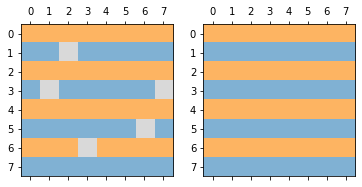

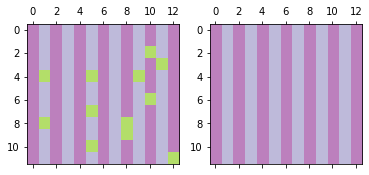

Test:

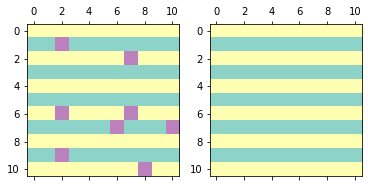

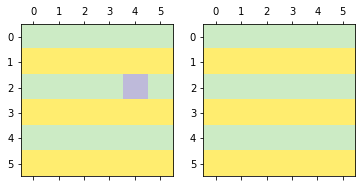

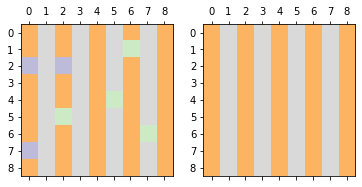

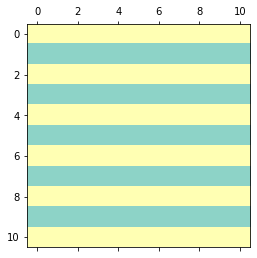

CleanUp1.json

|11111111111|00000000000|11111111111|00000000000|11111111111|00000000000|11111111111|00000000000|11111111111|00000000000|11111111111|

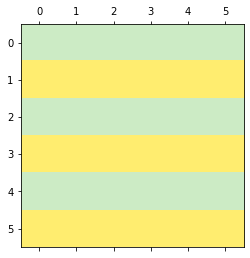

CleanUp1.json

|888888|999999|888888|999999|888888|999999|

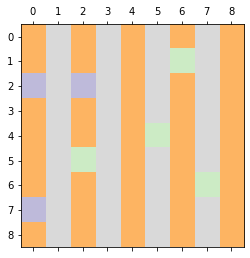

CleanUp1.json

|464646464|464646864|262646464|464646464|464648464|468646464|464646484|264646464|464646464|

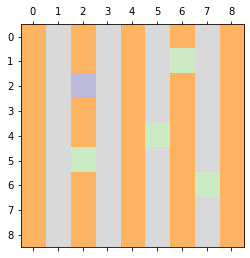

CleanUp1.json

|464646464|464646864|462646464|464646464|464648464|468646464|464646484|464646464|464646464|

,output_id,output
0,CleanUp1_1,|888888|999999|888888|999999|888888|999999|
1,CleanUp1_2,|464646464|464646864|262646464|464646464|46464...
2,CleanUp1_0,|11111111111|00000000000|11111111111|000000000...
3,CompleteShape7_0,
4,CopyMinimal_2,


In [22]:
params = {"skip_train": 1}
predictors= [
    ReconstructMosaic(params),
    ReconstructMosaicExtract(params),
]

preprocess_params = ["initial"]

color_params = ["coverage", "unique", "corners", "top", "grid"]

submission_list = run_parallel(
    test_files, 
    TEST_PATH, 
    predictors, 
    preprocess_params, 
    color_params, 
    timeout = 300, 
    processes = 2,
    max_memory_by_process = 0.5e+10,
    show_results = True
)

sub_df1 = generate_submission(submission_list, sample_submission)
sub_df1.head()

In [23]:
predictors= [Puzzle({"intersection": 0})]
                    
preprocess_params = [
    "initial",
    "block_with_side_colors",
    "min_max_blocks",
    "max_area_covered",
]

color_params = ["coverage", "unique", "corners", "top", "grid"]

submission_list = run_parallel(
    test_files, 
    TEST_PATH, 
    predictors, 
    preprocess_params, 
    color_params, 
    timeout = 300, 
    processes = 2,
    max_memory_by_process = 0.5e+10,
    show_results = True,
    process_whole_ds = True
)

sub_df2 = generate_submission(submission_list, sample_submission)
sub_df2.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,output_id,output
0,CompleteShape7_0,
1,CopyMinimal_2,
2,CompleteShape7_1,
3,00dbd492_0,
4,CopyMinimal_1,


# Public notebooks based solutions

The following code is based on https://www.kaggle.com/meaninglesslives/using-decision-trees-for-arc

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from xgboost import XGBClassifier
import pdb


training_path = other_data_dir / 'training'
evaluation_path = other_data_dir / 'evaluation'

def plot_result(test_input, test_prediction,
                input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Actual Target')
    test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Model Prediction')
    plt.tight_layout()
    plt.show()
    
def plot_test(test_prediction, task_name):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(test_prediction, cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(f'Test Prediction {task_name}')
    plt.tight_layout()
    plt.show()
    
# https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred



sample_sub1 = sample_submission.copy()
sample_sub1['output'] = ''
sample_sub1 = sample_sub1.set_index('output_id')


def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):

    if cur_row<=0: top = -1
    else: top = color[cur_row-1][cur_col]
        
    if cur_row>=nrows-1: bottom = -1
    else: bottom = color[cur_row+1][cur_col]
        
    if cur_col<=0: left = -1
    else: left = color[cur_row][cur_col-1]
        
    if cur_col>=ncols-1: right = -1
    else: right = color[cur_row][cur_col+1]
        
    return top, bottom, left, right

def get_tl_tr(color, cur_row, cur_col, nrows, ncols):
        
    if cur_row==0:
        top_left = -1
        top_right = -1
    else:
        if cur_col==0: top_left=-1
        else: top_left = color[cur_row-1][cur_col-1]
        if cur_col==ncols-1: top_right=-1
        else: top_right = color[cur_row-1][cur_col+1]   
        
    return top_left, top_right

def make_features(input_color, nfeat):
    nrows, ncols = input_color.shape
    feat = np.zeros((nrows*ncols,nfeat))
    cur_idx = 0
    for i in range(nrows):
        for j in range(ncols):
            feat[cur_idx,0] = i
            feat[cur_idx,1] = j
            feat[cur_idx,2] = input_color[i][j]
            feat[cur_idx,3:7] = get_moore_neighbours(input_color, i, j, nrows, ncols)
            feat[cur_idx,7:9] = get_tl_tr(input_color, i, j, nrows, ncols)
            feat[cur_idx,9] = len(np.unique(input_color[i,:]))
            feat[cur_idx,10] = len(np.unique(input_color[:,j]))
            feat[cur_idx,11] = (i+j)
            feat[cur_idx,12] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                         j-local_neighb:j+local_neighb]))

            cur_idx += 1
        
    return feat

def map_colors(input_color, target_color):
    flattened_target = np.array(target_color).reshape(-1,)
    unique_target_colors = np.unique(flattened_target)
    all_colors = np.array(range(0, 10))
    color_map = {unique_target_colors[i]: i for i in range(len(unique_target_colors))}
    remaining_colors = np.setdiff1d(all_colors, unique_target_colors)
    additional_color_map = {remaining_colors[i]: len(unique_target_colors) + i for i in range(len(remaining_colors))}
    color_map.update(additional_color_map)
    map_func = lambda x : color_map[x]
    input_color = np.array([[map_func(elt) for elt in row] for row in input_color])
    target_color = [[map_func(elt) for elt in row] for row in target_color]
    
    return input_color, target_color, color_map

def inverse_map_colors(color, color_map):
    map_func = lambda x : [key for key in color_map if color_map[key] == x][0]
    color = [[map_func(elt) for elt in row] for row in color]
    return np.array(color)
    
def features(task, mode='train'):
    num_train_pairs = len(task[mode])
    feat, target = [], []
    
    global local_neighb
    for task_num in range(num_train_pairs):
        input_color = task[mode][task_num]['input']
        target_color = task[mode][task_num]['output']
        
        # map colors so that the colors present in the target are the first n colors
        input_color, target_color, color_map = map_colors(input_color, target_color)

        nrows, ncols = len(task[mode][task_num]['input']), len(task[mode][task_num]['input'][0])

        target_rows, target_cols = len(task[mode][task_num]['output']), len(task[mode][task_num]['output'][0])
        
        if (target_rows!=nrows) or (target_cols!=ncols):
            print('Number of input rows:',nrows,'cols:',ncols)
            print('Number of target rows:',target_rows,'cols:',target_cols)
            not_valid=1
            return None, None, 1

        imsize = nrows*ncols
        feat.extend(make_features(input_color, nfeat))
        target.extend(np.array(target_color).reshape(-1,))
    
    return np.array(feat), np.array(target), 0

# mode = 'eval'
mode = 'test'
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path

all_task_ids = sorted(os.listdir(task_path))

nfeat = 13
local_neighb = 5
valid_scores = {}

model_accuracies = {'ens': []}
pred_taskids = []

for task_id in all_task_ids:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    xgb =  XGBClassifier(n_estimators=10, n_jobs=-1)
    xgb.fit(feat, target)


#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    for task_num in range(num_test_pairs):
        cur_idx = 0
        input_color = np.array(task['test'][task_num]['input'])
        input_color, _, color_map = map_colors(input_color, input_color)
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])
        feat = make_features(input_color, nfeat)

        print('Made predictions for ', task_id[:-5])

        preds = xgb.predict(feat).reshape(nrows,ncols)
        print(type(preds))
        preds = inverse_map_colors(preds, color_map)
        
        if (mode=='train') or (mode=='eval'):
            ens_acc = (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols)

            model_accuracies['ens'].append(ens_acc)

            pred_taskids.append(f'{task_id[:-5]}_{task_num}')

        preds = preds.astype(int).tolist()
        sample_sub1.loc[f'{task_id[:-5]}_{task_num}',
                       'output'] = flattener(preds)

Made predictions for  00dbd492
<class 'numpy.ndarray'>
Made predictions for  AboveBelow7
<class 'numpy.ndarray'>
Made predictions for  AboveBelow7
<class 'numpy.ndarray'>
Made predictions for  AboveBelow7
<class 'numpy.ndarray'>
Made predictions for  CleanUp1
<class 'numpy.ndarray'>
Made predictions for  CleanUp1
<class 'numpy.ndarray'>
Made predictions for  CleanUp1
<class 'numpy.ndarray'>
Made predictions for  CompleteShape7
<class 'numpy.ndarray'>
Made predictions for  CompleteShape7
<class 'numpy.ndarray'>
Made predictions for  CompleteShape7
<class 'numpy.ndarray'>
Made predictions for  CopyMinimal
<class 'numpy.ndarray'>
Made predictions for  CopyMinimal
<class 'numpy.ndarray'>
Made predictions for  CopyMinimal
<class 'numpy.ndarray'>
Made predictions for  TopBottom3D2
<class 'numpy.ndarray'>
Made predictions for  TopBottom3D2
<class 'numpy.ndarray'>
Made predictions for  TopBottom3D2
<class 'numpy.ndarray'>


The following code is based on https://www.kaggle.com/szabo7zoltan/colorandcountingmoduloq

400
400


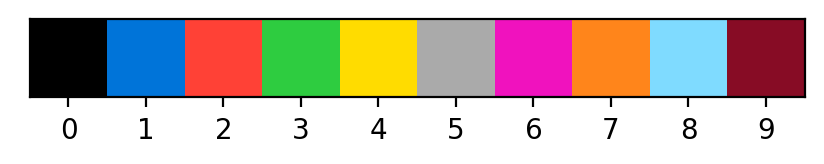

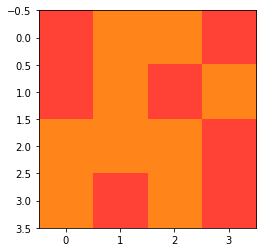

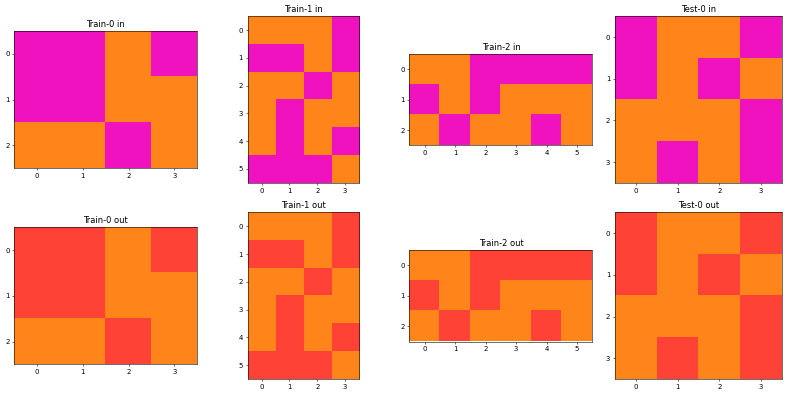

208


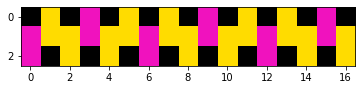

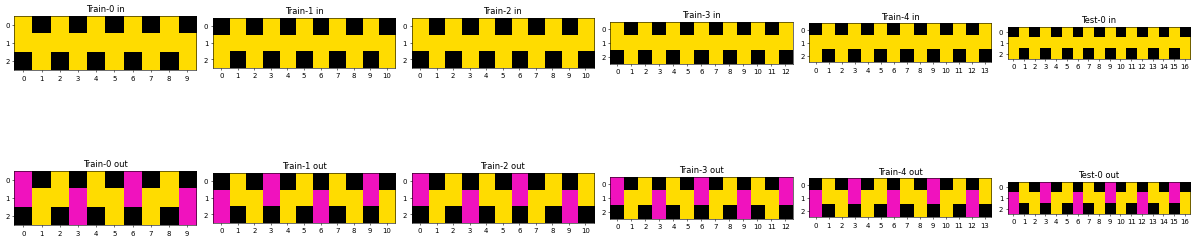

214


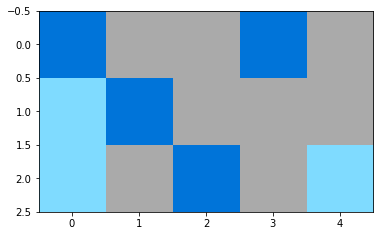

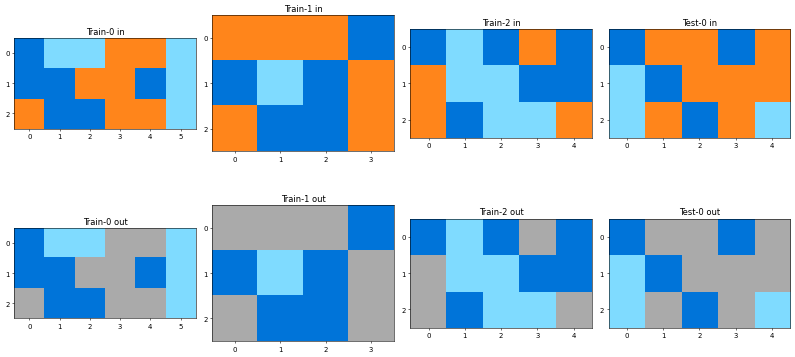

231


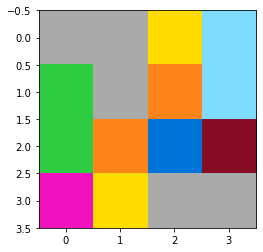

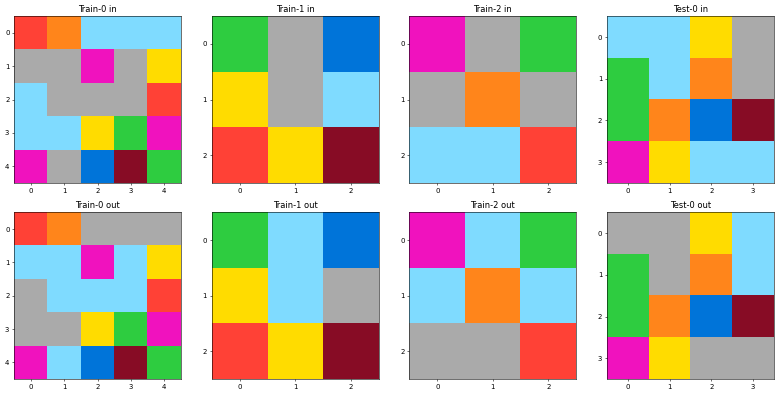

268


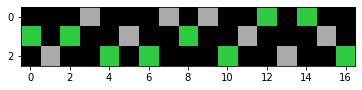

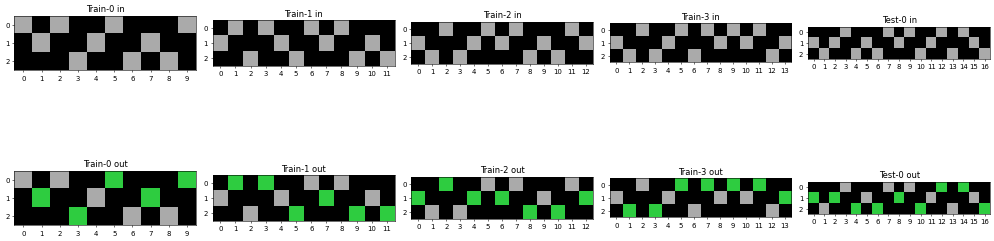

274


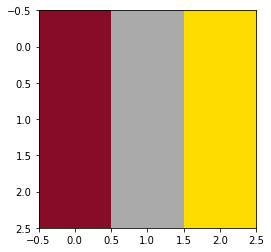

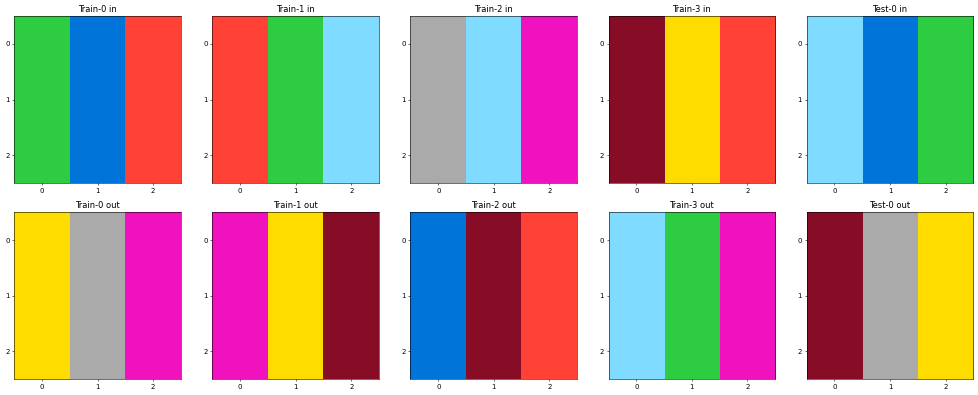

333


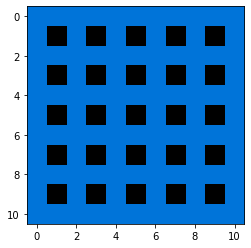

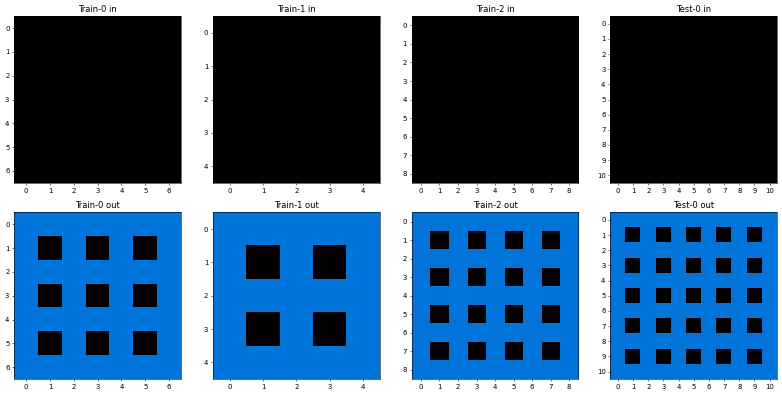

82


[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

|123|456|789|


In [25]:
# data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
# training_path = data_path / 'training'
# evaluation_path = data_path / 'evaluation'
# test_path = data_path / 'test'
training_tasks = sorted([f for f in os.listdir(training_path) if os.path.isfile(os.path.join(training_path, f)) and f.split(".")[-1] == "json"])
eval_tasks = sorted([f for f in os.listdir(evaluation_path) if os.path.isfile(os.path.join(evaluation_path, f)) and f.split(".")[-1] == "json"])

print(len(training_tasks))
print(len(eval_tasks))

T = training_tasks
Trains = []
for i in range(400):
    task_file = str(training_path / T[i])
    task = json.load(open(task_file, 'r'))
    Trains.append(task)
    
E = eval_tasks
Evals= []
for i in range(400):
    task_file = str(evaluation_path / E[i])
    task = json.load(open(task_file, 'r'))
    Evals.append(task)
    
    
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()
    
    
def Defensive_Copy(A): 
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()


def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output


def Recolor(task):
    Input = task[0]
    Output = task[1]
    Test_Picture = Input[-1]
    Input = Input[:-1]
    N = len(Input)
    
    for x, y in zip(Input, Output):
        if len(x) != len(y) or len(x[0]) != len(y[0]):
            return -1
        
    Best_Dict = -1
    Best_Q1 = -1
    Best_Q2 = -1
    Best_v = -1
    # v ranges from 0 to 3. This gives an extra flexibility of measuring distance from any of the 4 corners
    Pairs = []
    for t in range(15):
        for Q1 in range(1,8):
            for Q2 in range(1,8):
                if Q1+Q2 == t:
                    Pairs.append((Q1,Q2))
                    
    for Q1, Q2 in Pairs:
        for v in range(4):
    
  
            if Best_Dict != -1:
                continue
            possible = True
            Dict = {}
                      
            for x, y in zip(Input, Output):
                n = len(x)
                k = len(x[0])
                for i in range(n):
                    for j in range(k):
                        if v == 0 or v ==2:
                            p1 = i%Q1
                        else:
                            p1 = (n-1-i)%Q1
                        if v == 0 or v ==3:
                            p2 = j%Q2
                        else :
                            p2 = (k-1-j)%Q2
                        color1 = x[i][j]
                        color2 = y[i][j]
                        if color1 != color2:
                            rule = (p1, p2, color1)
                            if rule not in Dict:
                                Dict[rule] = color2
                            elif Dict[rule] != color2:
                                possible = False
            if possible:
                
                # Let's see if we actually solve the problem
                for x, y in zip(Input, Output):
                    n = len(x)
                    k = len(x[0])
                    for i in range(n):
                        for j in range(k):
                            if v == 0 or v ==2:
                                p1 = i%Q1
                            else:
                                p1 = (n-1-i)%Q1
                            if v == 0 or v ==3:
                                p2 = j%Q2
                            else :
                                p2 = (k-1-j)%Q2
                           
                            color1 = x[i][j]
                            rule = (p1,p2,color1)
                            
                            if rule in Dict:
                                color2 = 0 + Dict[rule]
                            else:
                                color2 = 0 + y[i][j]
                            if color2 != y[i][j]:
                                possible = False 
                if possible:
                    Best_Dict = Dict
                    Best_Q1 = Q1
                    Best_Q2 = Q2
                    Best_v = v
                
                
    if Best_Dict == -1:
        return -1 #meaning that we didn't find a rule that works for the traning cases
    
    #Otherwise there is a rule: so let's use it:
    n = len(Test_Picture)
    k = len(Test_Picture[0])
    
    answer = np.zeros((n,k), dtype = int)
   
    for i in range(n):
        for j in range(k):
            if Best_v == 0 or Best_v ==2:
                p1 = i%Best_Q1
            else:
                p1 = (n-1-i)%Best_Q1
            if Best_v == 0 or Best_v ==3:
                p2 = j%Best_Q2
            else :
                p2 = (k-1-j)%Best_Q2
           
            color1 = Test_Picture[i][j]
            rule = (p1, p2, color1)
            if (p1, p2, color1) in Best_Dict:
                answer[i][j] = 0 + Best_Dict[rule]
            else:
                answer[i][j] = 0 + color1
                                    
           
            
    return answer.tolist()


Function = Recolor

training_examples = []
for i in range(400):
    task = Trains[i]
    basic_task = Create(task,0)
    a = Function(basic_task)
  
    if  a != -1 and task['test'][0]['output'] == a:
        plot_picture(a)
        plot_task(task)
        print(i)
        training_examples.append(i)
        
        
evaluation_examples = []


for i in range(400):
    task = Evals[i]
    basic_task = Create(task,0)
    a = Function(basic_task)
    
    if a != -1 and task['test'][0]['output'] == a:
       
        plot_picture(a)
        plot_task(task)
        print(i)
        evaluation_examples.append(i)
        
        
sample_sub2 = sample_submission.copy()
sample_sub2.head()


def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred


example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

Solved = []
Problems = sample_sub2['output_id'].values
Proposed_Answers = []
for i in  range(len(Problems)):
    output_id = Problems[i]
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
   
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][j]['input']) for j in range(n)]
    Output = [Defensive_Copy(task['train'][j]['output']) for j in range(n)]
    Input.append(Defensive_Copy(task['test'][pair_id]['input']))
    
    solution = Recolor([Input, Output])
   
    
    pred = ''
        
    if solution != -1:
        Solved.append(i)
        pred1 = flattener(solution)
        pred = pred+pred1+' '
        
#     if pred == '':
#         pred = flattener(example_grid)
        
    Proposed_Answers.append(pred)
    
sample_sub2['output'] = Proposed_Answers

# Final predictions blend

In [26]:
final_submission = combine_submission_files([final_sub1, final_sub2, sub_df1,sub_df2, sample_sub1, sample_sub2],sample_submission)
final_submission.to_csv("submission.csv", index=False)

In [27]:
final_submission.head()

,output_id,output
0,00dbd492_0,|00000001110222220000|02222222221211121000|023...
1,AboveBelow7_0,|0000000000|0333033330|0030003300|0000000000|0...
2,AboveBelow7_1,|00000000000000|00000000000000|01111110000000|...
3,AboveBelow7_2,|222222222|000020000|000020000|000000000|00000...
4,CleanUp1_0,|00000000000|11111111111|00000000000|111111111...


In [28]:
"""
final_sub1.to_csv("final_sub1.csv")
final_sub2.to_csv("final_sub2.csv")
sub_df1.to_csv("sub_df1.csv")
sub_df2.to_csv("sub_df2.csv")
sample_sub1.to_csv("sample_sub1.csv")
sample_sub2.to_csv("sample_sub2.csv")
"""

'\nfinal_sub1.to_csv("final_sub1.csv")\nfinal_sub2.to_csv("final_sub2.csv")\nsub_df1.to_csv("sub_df1.csv")\nsub_df2.to_csv("sub_df2.csv")\nsample_sub1.to_csv("sample_sub1.csv")\nsample_sub2.to_csv("sample_sub2.csv")\n'